<a href="https://colab.research.google.com/github/TomBidewell/NLP_Project/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TF_IDF Embeddings


##Imports

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from itertools import combinations
from collections import defaultdict
from sklearn.metrics import ndcg_score
from transformers import BertPreTrainedModel, BertModel
from transformers import AutoConfig, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [ ]:
#downloading the predictions and results csv files
from google.colab import files


uploaded = files.upload()

Saving results_training.csv to results_training.csv


##Data Processing

Here we take our scraped data: the predictions (textual) and the numerical data and convert the predictions to a BoW representation for the 100 words in the vocabulary with the highest tf_idf scores

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#preparing predictions csv
df_preds = pd.read_csv("predictions_training.csv")


# clean the data
df_preds['Race Location'] = df_preds['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

df_preds = df_preds[df_preds['Date'] != 'Date']  #deleting rows with the column titles
df_preds = df_preds.reset_index()
df_preds = df_preds.drop("index", axis = 1)  #dropping index columns
df_preds = df_preds.replace('[\'NaN\']', np.nan)

#just want horse-race id and the predictions
df_preds['horse_race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"]+ "_" + df_preds["Horse Name"] #create horse id
df_preds = df_preds.drop(["Date", "Time", "Race Location", "Going", "Horse Name"], axis = 1) #drop all data now stored in horse id
df_preds = df_preds.drop_duplicates()
df_preds.Prediction = df_preds.Prediction.astype(str)
df_preds.horse_race_id = df_preds.horse_race_id.astype(str)
df_preds = df_preds.replace('-', np.nan)

for i in df_preds.columns[df_preds.isnull().any(axis=0)]:     # replace nan with the mean of a column
    df_preds[i].fillna(pd.to_numeric(df_preds[i]).mean(),inplace=True)


cols_to_norm = ['Horse Age', 'Horse Top Speed', 'Horse RPRS Ranking', 'Horse ORS Ranking', 'Horse Weight', 'Jockey Last 14', 'Trainer Last 14']

normalized_df_preds = df_preds[cols_to_norm].astype(float)  #standardize the data
normalized_df_preds = (normalized_df_preds-normalized_df_preds.mean())/normalized_df_preds.std()

df_preds[cols_to_norm] = normalized_df_preds

df_preds['horse_race_id'] = df_preds['horse_race_id'].apply(lambda x: x.strip())



In [ ]:
#prepare the results csv
df_res = pd.read_csv("results_training.csv")

df_res['Race Location'] = df_res['Race Location'].str.replace(r'\(.*?\)', '', regex=True)


#as above
df_res = df_res[df_res['Date'] != 'Date']
df_res = df_res.drop_duplicates()
df_res = df_res.reset_index()
df_res = df_res.drop("index", axis = 1)
df_res['horse_race_id'] = df_res['Date']+ "_" + df_res['Time'] + "_" + df_res["Race Location"]+ "_" + df_res["Horse Name"]
df_res = df_res[["horse_race_id", "Position"]]

def get_type(x):  #sometimes position is text ie NR for the horse being a Non_Runne, want to penalise this so give a high score
    try:
        return float(x)
    except:
        return 100


df_res['Position'] = df_res['Position'].apply(get_type) #apply the above function to Position values
df_res.reset_index(inplace = True)
df_res = df_res.drop(["index"], axis = 1)
df_res.horse_race_id = df_res.horse_race_id.astype(str)
df_res['horse_race_id'] = df_res['horse_race_id'].apply(lambda x: x.strip())

In [ ]:
#merge the two to get our data
df = pd.merge(df_preds, df_res, on='horse_race_id')

df['Race_Id'] = df['horse_race_id'].apply(lambda x: "_".join(x.split("_")[:3]))
df = df.drop_duplicates(subset='horse_race_id')
df = df.reset_index()
df = df.drop("index", axis = 1)  #dropping index columns
df = df.drop("Unnamed: 0", axis = 1)
df = df.head(100)

In [ ]:
#clean text data:

df['Prediction'] = df['Prediction'].apply(lambda x: x.lower())  #make all lowercase
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','')   #remove punctuation

<ipython-input-8-584b2841ef84>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','')   #remove punctuation


In [ ]:
df.to_csv("data.csv")
df.head()

,Horse Age,Horse Top Speed,Horse RPRS Ranking,Horse ORS Ranking,Horse Weight,Prediction,Jockey Last 14,Trainer Last 14,horse_race_id,Position,Race_Id
0,-0.991158,-2.903467,-0.033883,2.115579e-01,-0.191188,22 over 7f both wins on aw remains open to fur...,0.878183,0.702050,18-04-2023_1:50_Newmarket_Think Climate,9.0,18-04-2023_1:50_Newmarket
1,-0.991158,0.101572,-0.331542,1.651578e-01,-0.390760,ran well in france on final 2yo start more is ...,-1.087826,-0.896703,18-04-2023_1:50_Newmarket_Awtaad Prince,7.0,18-04-2023_1:50_Newmarket
2,-0.991158,0.487934,0.008640,-6.593846e-16,-0.390760,one of two runners for charlie appleby made al...,-0.301422,2.140927,18-04-2023_1:50_Newmarket_City Of Kings,6.0,18-04-2023_1:50_Newmarket
3,-0.991158,0.230359,-0.118928,-6.593846e-16,-0.390760,solid third in the convivial maiden then won w...,0.976483,-0.097326,18-04-2023_1:50_Newmarket_Hi Royal,4.0,18-04-2023_1:50_Newmarket
4,-0.991158,0.573792,0.178731,4.435582e-01,-0.390760,major player on rprs and looks likely to give ...,-0.498023,0.622112,18-04-2023_1:50_Newmarket_Holguin,2.0,18-04-2023_1:50_Newmarket


In [ ]:
#embed the predicitons with the tf_idf BoW representation

def add_tf_idf(df, n):
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the "Prediction" column
    tfidf_separate = tfidf_vectorizer.fit_transform(df["Prediction"])

    # Get the vocabulary and its corresponding indices
    vocab = tfidf_vectorizer.vocabulary_
    vocab_indices = tfidf_vectorizer.get_feature_names_out()

    # Sum the tf-idf values for each word for each document (i.e., summing the columns of the tfidf_separate matrix above)
    combined_tfidf = tfidf_separate.toarray().sum(axis=0)

    # Sort the combined_tfidf values in descending order and take the first n indices
    indices_n_highest = combined_tfidf.argsort()[::-1][:n]

    # Get the words corresponding to the highest tf-idf values
    words_n_highest = [vocab_indices[i] for i in indices_n_highest]

    #perform BOW using the highest tfidf words as our set of words
    bow_counter = CountVectorizer()
    bow_counter.fit(words_n_highest)
    bow_applied = bow_counter.transform(df['Prediction'])

    #add these new values to the dataframe
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(bow_applied.toarray()).reset_index(drop=True)], axis=1)
    return(df)

#add this new data, can go higher than 100
df = add_tf_idf(df, 100)

#drop the prediction sentences
df = df.drop('Prediction', axis = 1)

df.to_csv("tf_idf_data.csv")

In [ ]:
df.head()

,Horse Age,Horse Top Speed,Horse RPRS Ranking,Horse ORS Ranking,Horse Weight,Jockey Last 14,Trainer Last 14,horse_race_id,Position,Race_Id,...,90,91,92,93,94,95,96,97,98,99
0,-0.991158,-2.903467,-0.033883,2.115579e-01,-0.191188,0.878183,0.702050,18-04-2023_1:50_Newmarket_Think Climate,9.0,18-04-2023_1:50_Newmarket,...,0,0,0,0,1,0,0,0,0,0
1,-0.991158,0.101572,-0.331542,1.651578e-01,-0.390760,-1.087826,-0.896703,18-04-2023_1:50_Newmarket_Awtaad Prince,7.0,18-04-2023_1:50_Newmarket,...,0,0,0,0,0,0,0,0,0,0
2,-0.991158,0.487934,0.008640,-6.593846e-16,-0.390760,-0.301422,2.140927,18-04-2023_1:50_Newmarket_City Of Kings,6.0,18-04-2023_1:50_Newmarket,...,0,0,0,0,0,0,0,0,0,0
3,-0.991158,0.230359,-0.118928,-6.593846e-16,-0.390760,0.976483,-0.097326,18-04-2023_1:50_Newmarket_Hi Royal,4.0,18-04-2023_1:50_Newmarket,...,0,0,0,0,0,0,1,0,1,0
4,-0.991158,0.573792,0.178731,4.435582e-01,-0.390760,-0.498023,0.622112,18-04-2023_1:50_Newmarket_Holguin,2.0,18-04-2023_1:50_Newmarket,...,0,0,0,0,0,0,0,0,0,0


##Pointwise (Regression)
A regression model taking in a horse's embeddings and trying to predict its position.

In [ ]:
ptwise_df = pd.read_csv("tf_idf_data.csv")
#clean data
ptwise_df = ptwise_df.drop(ptwise_df.columns[0], axis = 1)
ptwise_df = ptwise_df.drop(['horse_race_id', 'Race_Id'], axis = 1)

#create datasets for train test and val data
class PointwiseDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]

        # Extract the input features and target
        features = torch.tensor(sample.drop('Position').values, dtype=torch.float32)
        target = torch.tensor(sample['Position'], dtype=torch.float32)

        return features, target

# Split the dataframe into train, validation, and test sets
pt_train_df, pt_test_df = train_test_split(ptwise_df, test_size=0.2, random_state=42)
pt_train_df, pt_val_df = train_test_split(pt_train_df, test_size=0.2, random_state=42)

# Create the train, validation, and test datasets
pt_train_dataset = PointwiseDataset(pt_train_df)
pt_val_dataset = PointwiseDataset(pt_val_df)
pt_test_dataset = PointwiseDataset(pt_test_df)

batch_size = 32
pt_train_dataloader = DataLoader(pt_train_dataset, batch_size=batch_size, shuffle=True)
pt_val_dataloader = DataLoader(pt_val_dataset, batch_size=batch_size)
pt_test_dataloader = DataLoader(pt_test_dataset, batch_size=batch_size)

In [ ]:
#define our model

class Pointwise(nn.Module):  # inheriting from nn.Module

    def __init__(self, emb_size, hidden_layer_size, dropout):
        """ - d is the size of the vectors representing the objects to classify
            - hidden_layer_size is ... the size of the hidden layer
        """
        super(Pointwise, self).__init__()
        self.linear_1 = nn.Linear(emb_size, hidden_layer_size)
        self.linear_2 = nn.Linear(hidden_layer_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.linear_1(X)  # out shape (batch_size, hidden_layer_size)
        out = self.relu(out)  # same shape
        out = self.dropout(out)
        out = self.linear_2(out)  # out shape (batch_size, nb_classes)
        return out  # no need to reshape the output

emb_size = 107
hidden_layer_size = 200
dropout = 0.2

pointwise = Pointwise(emb_size, hidden_layer_size, dropout)

In [ ]:
#training

num_epochs = 1000
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(pointwise.parameters(), lr=learning_rate)


pt_training_loss = []
pt_validation_loss = []
# Training loop
for epoch in range(num_epochs):
    pointwise.train()  # Set the model to training mode

    running_loss = 0.0

    # Training the model

    with tqdm(pt_train_dataloader, unit="batch") as tepoch:

        for features, y_true in tepoch:

            optimizer.zero_grad()

            y_pred = pointwise(features)

            loss = loss_function(y_pred, y_true.unsqueeze(1))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(pt_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    pt_training_loss.append(average_loss)

    # Validation loop
    pointwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for features, y_true in pt_val_dataloader:
            y_pred = pointwise(features)
            loss = loss_function(y_pred, y_true.unsqueeze(1))
            val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(pt_val_dataloader)
    print(f"Validation Loss: {average_val_loss} \n")
    pt_validation_loss.append(average_val_loss)

    if epoch == 0:
        previous_dev_loss = average_val_loss
        dev_loss_counter = 0
    else:
      if average_val_loss >= previous_dev_loss:
          dev_loss_counter += 1
          previous_dev_loss = average_val_loss
          if dev_loss_counter > 3:
              print("Early Stopping")
              break
      else:
          previous_dev_loss = average_val_loss
          dev_loss_counter = 0

# Testing loop
pointwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for features, y_true in pt_test_dataloader:
        y_pred = pointwise(features)
        loss = loss_function(y_pred, y_true.unsqueeze(1))
        test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(pt_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")

100%|██████████| 146/146 [00:03<00:00, 42.86batch/s]


Epoch 1/1000, Loss: 508.7369662441619
Validation Loss: 494.18363633026945 



100%|██████████| 146/146 [00:03<00:00, 48.33batch/s]


Epoch 2/1000, Loss: 446.784600035785
Validation Loss: 486.54910288630305 



100%|██████████| 146/146 [00:03<00:00, 48.05batch/s]


Epoch 3/1000, Loss: 438.34720068108544
Validation Loss: 483.7591822856181 



100%|██████████| 146/146 [00:03<00:00, 38.24batch/s]


Epoch 4/1000, Loss: 432.2318009154437
Validation Loss: 480.6885499696474 



100%|██████████| 146/146 [00:02<00:00, 49.15batch/s]


Epoch 5/1000, Loss: 428.2526635470456
Validation Loss: 480.1289576968631 



100%|██████████| 146/146 [00:02<00:00, 49.71batch/s]


Epoch 6/1000, Loss: 424.147105230044
Validation Loss: 480.5925911568307 



100%|██████████| 146/146 [00:03<00:00, 39.99batch/s]


Epoch 7/1000, Loss: 420.4597669105007
Validation Loss: 480.5207772126069 



100%|██████████| 146/146 [00:02<00:00, 49.05batch/s]


Epoch 8/1000, Loss: 416.01900986449357
Validation Loss: 481.5027891623007 



100%|██████████| 146/146 [00:02<00:00, 49.54batch/s]


Epoch 9/1000, Loss: 413.388486208981
Validation Loss: 481.6837014894228 



100%|██████████| 146/146 [00:03<00:00, 47.73batch/s]


Epoch 10/1000, Loss: 410.75761136616745
Validation Loss: 482.4965492454735 



100%|██████████| 146/146 [00:03<00:00, 38.94batch/s]


Epoch 11/1000, Loss: 407.7273079989708
Validation Loss: 483.37525022352065 

Early Stopping
Average Test Loss: 477.8223374408224


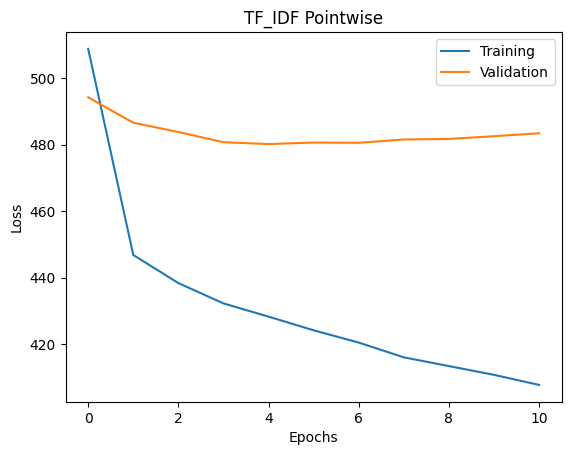

In [ ]:
plt.plot(pt_training_loss, label = 'Training')
plt.plot(pt_validation_loss, label = 'Validation')

plt.title("TF_IDF Pointwise")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##Pairwise (Classification)
For every race, we take every combination of pairs of horses and predict which of the two will win. Although this is binary classification and logistic regression could be used, given the above model is regression, we wanted to try classification. Note for every pair of horses, we subtract their embeddings to keep the number of parameters low (rather than concatenating the embeddings).

###Data Preparation for Binary


In [ ]:
df = pd.read_csv("tf_idf_data.csv")
df = df.drop(df.columns[0], axis = 1)

# Initialize a defaultdict to store the results
results_dict = defaultdict(list)

# Get unique race IDs
race_ids = df['Race_Id'].unique()

# Iterate over race IDs
for race_id in race_ids:
    # Get the rows for the current race ID
    rows = df[df['Race_Id'] == race_id]

    # Iterate over all combinations of horse IDs in the current race
    for i, j in combinations(rows.index, 2):
        # Store the common information
        results_dict['Race_Id'].append(race_id)
        results_dict['Position_x'].append(rows.loc[i, 'Position'])
        results_dict['Position_y'].append(rows.loc[j, 'Position'])

        # Calculate the differences between the values for each column
        # Calculate the differences between the values for each column
        for col_name in [col for col in rows.columns if col not in ['horse_race_id', 'Position', 'Race_Id']]:
            col_diff = float(rows.loc[i, col_name]) - float(rows.loc[j, col_name])
            results_dict[col_name].append(col_diff)

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

def positions(x):
    if x['Position_x'] > x['Position_y']: #if horse 1 finishes later than horse 2
        return 0
    else:
        return 1

results_df['comparison'] = results_df[['Position_x', 'Position_y']].apply(positions, axis = 1)

df = results_df.drop(['Race_Id', 'Position_x', 'Position_y'], axis = 1)

In [ ]:
df.head()

,Horse Age,Horse Top Speed,Horse RPRS Ranking,Horse ORS Ranking,Horse Weight,Jockey Last 14,Trainer Last 14,0,1,2,...,91,92,93,94,95,96,97,98,99,comparison
0,0.0,-3.005039,0.297660,0.046400,0.199572,1.966009,1.598753,0.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,0.0,-3.391401,-0.042523,0.211558,0.199572,1.179605,-1.438877,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.0,-3.133826,0.085046,0.211558,0.199572,-0.098300,0.799376,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,-1.0,0
3,0.0,-3.477260,-0.212614,-0.232000,0.199572,1.376206,0.079938,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,0.0,-2.575748,-0.085046,0.211558,0.199572,0.000000,-1.438877,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


###Pairwise Model


In [ ]:
class Pairwise_Dataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]

        # Extract the input features and target
        features = torch.tensor(sample.drop('comparison').values, dtype=torch.float32)
        target = torch.tensor(sample['comparison'], dtype=torch.float32)

        return features, target.type(torch.LongTensor)

# Split the dataframe into train, validation, and test sets
pr_train_df, pr_test_df = train_test_split(df, test_size=0.2, random_state=42)
pr_train_df, pr_val_df = train_test_split(pr_train_df, test_size=0.2, random_state=42)

# Create the train, validation, and test datasets
pr_train_dataset = Pairwise_Dataset(pr_train_df)
pr_val_dataset = Pairwise_Dataset(pr_val_df)
pr_test_dataset = Pairwise_Dataset(pr_test_df)

batch_size = 32
pr_train_dataloader = DataLoader(pr_train_dataset, batch_size=batch_size, shuffle=True)
pr_val_dataloader = DataLoader(pr_val_dataset, batch_size=batch_size)
pr_test_dataloader = DataLoader(pr_test_dataset, batch_size=batch_size)

In [ ]:
class Pairwise(nn.Module):
    def __init__(self, embs_size, hidden_layer_size, dropout_prob):
        super(Pairwise, self).__init__()
        self.embs_size = embs_size
        self.linear1 = nn.Linear(embs_size, hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size, 2)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, X):
        out = self.linear1(X)
        out = nn.ReLU()(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.dropout(out)
        return F.log_softmax(out, dim=1)

embs_size = 107
hidden_layer_size = 200
dropout_prob = 0.5

pairwise = Pairwise(embs_size, hidden_layer_size, dropout_prob)

In [ ]:
#training

num_epochs = 1000
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(pairwise.parameters(), lr=learning_rate)

pr_training_loss = []
pr_training_accuracy = []
pr_validation_loss = []
pr_validation_accuracy = []

# Training loop
for epoch in range(num_epochs):
    pairwise.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(pr_train_dataloader, unit="batch") as tepoch:
            # Training the model
            for features, y_true in tepoch:

                optimizer.zero_grad()

                y_pred = pairwise(features)

                loss = loss_function(y_pred, y_true)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                total += y_true.size(0)
                y_label = torch.argmax(y_pred, axis =1)
                correct += torch.sum(y_label == y_true).item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(pr_train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    pr_training_loss.append(average_loss)

    tr_epoch_av = (100 * correct / total)
    print('Accuracy of epoch: %d %%' % tr_epoch_av)
    pr_training_accuracy.append(tr_epoch_av)

    # Validation loop
    pairwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for features, y_true in pr_val_dataloader:
            y_pred = pairwise(features)
            loss = loss_function(y_pred, y_true)
            val_loss += loss.item()

            val_total += y_true.size(0)
            y_label = torch.argmax(y_pred, axis =1)
            val_correct += torch.sum(y_label == y_true).item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(pr_val_dataloader)
    print(f"Validation Loss: {average_val_loss}")
    pr_validation_loss.append(average_val_loss)

    val_epoch_av = (100 * val_correct / val_total)
    print('Validation accuracy of epoch: %d %% \n' % val_epoch_av)
    pr_validation_accuracy.append(val_epoch_av)

    if epoch == 0:
        previous_dev_loss = average_val_loss
        dev_loss_counter = 0
    else:
      if average_val_loss >= previous_dev_loss:
          dev_loss_counter += 1
          previous_dev_loss = average_val_loss
          if dev_loss_counter > 3:
              print("Early Stopping")
              break
      else:
          previous_dev_loss = average_val_loss
          dev_loss_counter = 0


# Testing loop
pairwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for features, y_true in pr_test_dataloader:
        y_pred = pairwise(features)
        loss = loss_function(y_pred, y_true)
        test_loss += loss.item()

        test_total += y_true.size(0)
        y_label = torch.argmax(y_pred, axis =1)
        test_correct += torch.sum(y_label == y_true).item()

# Print the average test loss
average_test_loss = test_loss / len(pr_test_dataloader)
print(f"Average Test Loss: {average_test_loss}")
print('Accuracy of epoch: %d %%' % (100 * test_correct / test_total))

100%|██████████| 637/637 [00:16<00:00, 39.34batch/s]


Epoch 1/1000, Loss: 0.6890126335751879
Accuracy of epoch: 52 %
Validation Loss: 0.6682984929531812
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:14<00:00, 44.41batch/s]


Epoch 2/1000, Loss: 0.6767307192414671
Accuracy of epoch: 55 %
Validation Loss: 0.6664472851902247
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:14<00:00, 42.71batch/s]


Epoch 3/1000, Loss: 0.6751166116124607
Accuracy of epoch: 55 %
Validation Loss: 0.6645613610744476
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:15<00:00, 40.01batch/s]


Epoch 4/1000, Loss: 0.6738552950802179
Accuracy of epoch: 56 %
Validation Loss: 0.6677284896373749
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:14<00:00, 44.48batch/s]


Epoch 5/1000, Loss: 0.6688032911935444
Accuracy of epoch: 57 %
Validation Loss: 0.667020496726036
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:14<00:00, 44.44batch/s]


Epoch 6/1000, Loss: 0.6642771940590635
Accuracy of epoch: 57 %
Validation Loss: 0.6636006467044353
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:14<00:00, 43.91batch/s]


Epoch 7/1000, Loss: 0.659691275756812
Accuracy of epoch: 58 %
Validation Loss: 0.664877612516284
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:14<00:00, 44.56batch/s]


Epoch 8/1000, Loss: 0.6570779989989624
Accuracy of epoch: 58 %
Validation Loss: 0.6657707124948502
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:17<00:00, 36.81batch/s]


Epoch 9/1000, Loss: 0.6537392261076946
Accuracy of epoch: 59 %
Validation Loss: 0.6656947411596775
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:14<00:00, 44.33batch/s]


Epoch 10/1000, Loss: 0.6473925527261228
Accuracy of epoch: 60 %
Validation Loss: 0.6644075244665146
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:14<00:00, 44.59batch/s]


Epoch 11/1000, Loss: 0.6436409036068939
Accuracy of epoch: 60 %
Validation Loss: 0.664965083450079
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:14<00:00, 44.36batch/s]


Epoch 12/1000, Loss: 0.6402543643767269
Accuracy of epoch: 60 %
Validation Loss: 0.6634740341454745
Validation accuracy of epoch: 59 % 



100%|██████████| 637/637 [00:14<00:00, 44.82batch/s]


Epoch 13/1000, Loss: 0.6372776907317492
Accuracy of epoch: 61 %
Validation Loss: 0.6617977965623141
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:13<00:00, 45.60batch/s]


Epoch 14/1000, Loss: 0.6332822051864216
Accuracy of epoch: 61 %
Validation Loss: 0.6620451167225838
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:14<00:00, 45.06batch/s]


Epoch 15/1000, Loss: 0.6283478045388705
Accuracy of epoch: 62 %
Validation Loss: 0.6606668945401907
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:14<00:00, 44.99batch/s]


Epoch 16/1000, Loss: 0.6257919305160619
Accuracy of epoch: 62 %
Validation Loss: 0.6610942337661981
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:14<00:00, 43.25batch/s]


Epoch 17/1000, Loss: 0.6241678344772974
Accuracy of epoch: 62 %
Validation Loss: 0.6616465363651514
Validation accuracy of epoch: 61 % 



100%|██████████| 637/637 [00:14<00:00, 44.69batch/s]


Epoch 18/1000, Loss: 0.6183890265703575
Accuracy of epoch: 63 %
Validation Loss: 0.6634604625403882
Validation accuracy of epoch: 60 % 



100%|██████████| 637/637 [00:14<00:00, 45.13batch/s]


Epoch 19/1000, Loss: 0.6153111025995138
Accuracy of epoch: 63 %
Validation Loss: 0.6637446902692318
Validation accuracy of epoch: 60 % 

Early Stopping
Average Test Loss: 0.6699598584342842
Accuracy of epoch: 58 %


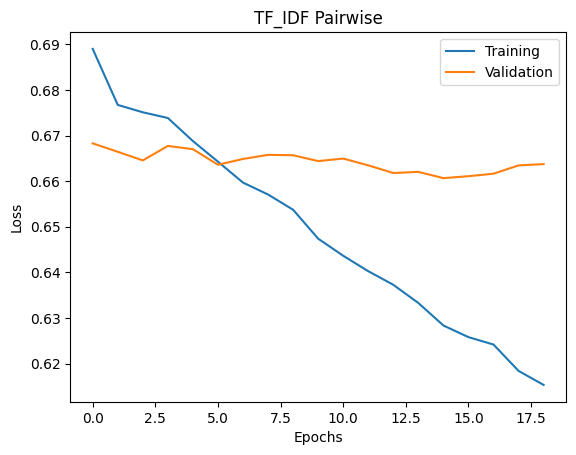

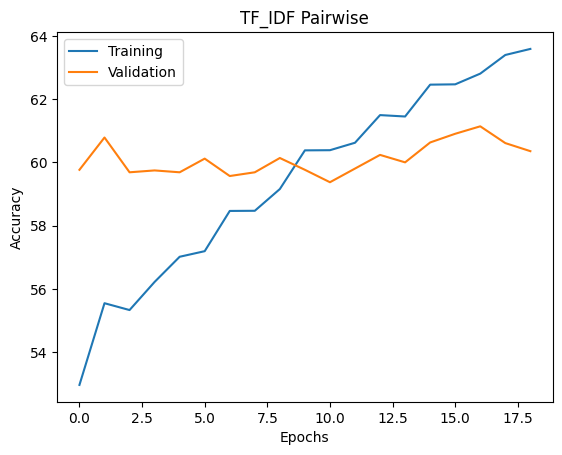

In [ ]:
plt.plot(pr_training_loss, label = 'Training')
plt.plot(pr_validation_loss, label = 'Validation')
plt.title("TF_IDF Pairwise")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(pr_training_accuracy , label = 'Training')
plt.plot(pr_validation_accuracy, label = 'Validation')
plt.title("TF_IDF Pairwise")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


#BERT Embeddings

To obtain better results, we decided to use BERT to embed our predictions. We took the '[cls]' token and concatenated it with the numerical data to form an embedding for a horse.

In [ ]:
#since using BERT, switch to using GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')
print("Using {}.".format(device))

Using cuda:0.


## Pointwise (Regression)

In [ ]:
df = pd.read_csv("data.csv")
df = df.drop([df.columns[0], df.columns[9], df.columns[11]], axis = 1)
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the column
normalized_column = scaler.fit_transform(df[['Position']])

# Update the column in the DataFrame
df['Position'] = normalized_column

#clean text data:

df['Prediction'] = df['Prediction'].apply(lambda x: x.lower())  #make all lowercase
df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','')   #remove punctuation

df.head()

<ipython-input-43-b5ee6bbd421f>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Prediction"] = df['Prediction'].str.replace('[^\w\s]','')   #remove punctuation


,Horse Age,Horse Top Speed,Horse RPRS Ranking,Horse ORS Ranking,Horse Weight,Prediction,Jockey Last 14,Trainer Last 14,Position
0,-0.991158,-2.903467,-0.033883,2.115579e-01,-0.191188,22 over 7f both wins on aw remains open to fur...,0.878183,0.702050,0.080808
1,-0.991158,0.101572,-0.331542,1.651578e-01,-0.390760,ran well in france on final 2yo start more is ...,-1.087826,-0.896703,0.060606
2,-0.991158,0.487934,0.008640,-6.593846e-16,-0.390760,one of two runners for charlie appleby made al...,-0.301422,2.140927,0.050505
3,-0.991158,0.230359,-0.118928,-6.593846e-16,-0.390760,solid third in the convivial maiden then won w...,0.976483,-0.097326,0.030303
4,-0.991158,0.573792,0.178731,4.435582e-01,-0.390760,major player on rprs and looks likely to give ...,-0.498023,0.622112,0.010101


In [ ]:
train_and_val_data, test_data = train_test_split( df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_and_val_data, test_size=0.2, random_state=42)

In [ ]:
word_count_train = train_and_val_data['Prediction'].apply(lambda x: len(x.split()))
word_count_test = test_data['Prediction'].apply(lambda x: len(x.split()))

<ipython-input-46-e2b2cfe2900d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count_train, label = 'train', color=sns.xkcd_rgb['red'])
<ipython-input-46-e2b2cfe2900d>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_count_test, label = 'test', color=sns.xkcd_rgb['blue'])


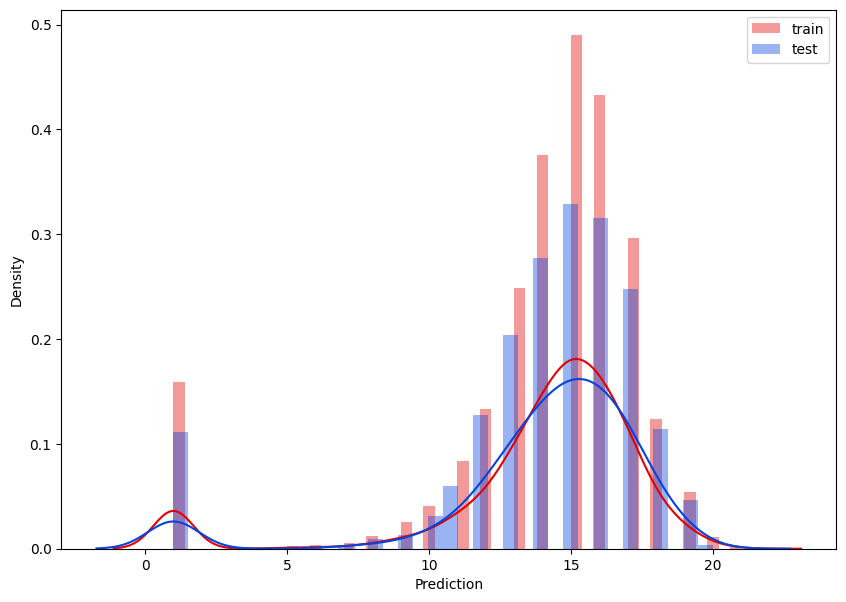

In [ ]:
fig = plt.figure(figsize=[10,7])
sns.distplot(word_count_train, label = 'train', color=sns.xkcd_rgb['red'])
sns.distplot(word_count_test, label = 'test', color=sns.xkcd_rgb['blue'])
plt.legend()
plt.show()

In [ ]:
max_train_word_count = word_count_train.max()

In [ ]:
MAX_LEN_TRAIN = max_train_word_count
MAX_LEN_VALID = max_train_word_count
MAX_LEN_TEST = max_train_word_count

In [ ]:
class BERT_Pointwise_Dataset(Dataset):

    def __init__(self, data, maxlen, tokenizer):
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):

        # Extract the input features and target
        num_features = torch.tensor(self.df.drop(['index', 'Prediction', 'Position'], axis=1).iloc[index].values, dtype=torch.float32)

        #Select the sentence and label at the specified index in the data frame
        pred = self.df.loc[index, 'Prediction']
        try:
            position = self.df.loc[index, 'Position']
        except:
            position = -1.0

        #Preprocess the text to be suitable for the transformer
        tokens = self.tokenizer.tokenize(pred)
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids)
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()

        position = torch.tensor(position, dtype=torch.float32)

        return num_features, input_ids, attention_mask, position

In [ ]:
BATCH_SIZE = 64
config = AutoConfig.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
## Training Dataset
train_set = BERT_Pointwise_Dataset(data=train_data, maxlen=MAX_LEN_TRAIN, tokenizer=tokenizer)
valid_set = BERT_Pointwise_Dataset(data=val_data, maxlen=MAX_LEN_VALID, tokenizer=tokenizer)
test_set = BERT_Pointwise_Dataset(data=test_data, maxlen=MAX_LEN_TEST, tokenizer=tokenizer)


## Data Loaders
bert_pointwise_train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE)
bert_pointwise_valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE)
bert_pointwise_test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE)

In [ ]:

class BERT_Pointwise(BertPreTrainedModel):
    def __init__(self, config, hidden_layer_size, freeze_bert=False, dropout = 0):
        super().__init__(config)
        self.bert = BertModel(config)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        #The output layer that takes model = XLMRobertaModel.from_pretrained("xlm-roberta-base")the [CLS] representation and gives an output
        self.cls_linear1 = nn.Linear(config.hidden_size + 7, hidden_layer_size)   #note the +7 to add the numerical data on the end
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_layer_size,1)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)



    def forward(self, num_features, input_ids, attention_mask):
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]

        X = torch.cat((num_features, logits), -1).to(torch.float32)  #concatenate the numerical and textual data

        output = self.cls_linear1(X)
        output = self.relu1(output)
        output = self.dropout1(output)
        output = self.linear2(output)
        output = self.dropout2(output)
        return output



###Fine-tune

In [ ]:
#training
bert_pointwise = BERT_Pointwise(config, 200, freeze_bert = False, dropout = 0.5).to(device)


num_epochs = 1000
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(bert_pointwise.parameters(), lr=learning_rate)

bert_pt_training_loss = []
bert_pt_val_loss = []


# Training loop
for epoch in range(num_epochs):
    bert_pointwise.train()  # Set the model to training mode

    running_loss = 0.0

    # Training the model
    with tqdm(bert_pointwise_train_loader, unit="batch") as tepoch:
          for num_features, input_ids, attention_mask, true_position in tepoch:

              num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

              optimizer.zero_grad()

              pred_position = bert_pointwise(num_features, input_ids, attention_mask)

              loss = loss_function(pred_position, true_position.unsqueeze(1))

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(bert_pointwise_train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    bert_pt_training_loss.append(average_loss)

    # Validation loop
    bert_pointwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(bert_pointwise_valid_loader, unit="batch") as tepoch:

            for num_features, input_ids, attention_mask, true_position in tepoch:

                num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

                pred_position = bert_pointwise(num_features, input_ids, attention_mask)

                loss = loss_function(pred_position, true_position.unsqueeze(1))

                val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(bert_pointwise_valid_loader)
    print(f"Validation Loss: {average_val_loss} \n")
    bert_pt_val_loss.append(average_val_loss)

    if epoch == 0:
        previous_dev_loss = average_val_loss
        dev_loss_counter = 0
    else:
      if average_val_loss >= previous_dev_loss:
          dev_loss_counter += 1
          previous_dev_loss = average_val_loss
          if dev_loss_counter > 3:
              print("Early Stopping")
              break
      else:
          previous_dev_loss = average_val_loss
          dev_loss_counter = 0

# Testing loop
bert_pointwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
  with tqdm(bert_pointwise_test_loader, unit="batch") as tepoch:
        for num_features, input_ids, attention_mask, true_position in tepoch:

                num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

                pred_position = bert_pointwise(num_features, input_ids, attention_mask)

                loss = loss_function(pred_position, true_position.unsqueeze(1))

                test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(bert_pointwise_test_loader)
print(f"Average Test Loss: {average_test_loss}")

100%|██████████| 73/73 [00:22<00:00,  3.26batch/s]


Epoch 1/1000, Loss: 0.6573088340499528


100%|██████████| 19/19 [00:01<00:00,  9.95batch/s]


Validation Loss: 0.0559390880853722 



100%|██████████| 73/73 [00:19<00:00,  3.69batch/s]


Epoch 2/1000, Loss: 0.055000526377650565


100%|██████████| 19/19 [00:02<00:00,  8.62batch/s]


Validation Loss: 0.056660515819921306 



100%|██████████| 73/73 [00:19<00:00,  3.66batch/s]


Epoch 3/1000, Loss: 0.05436471388164959


100%|██████████| 19/19 [00:01<00:00,  9.81batch/s]


Validation Loss: 0.05537103242731016 



100%|██████████| 73/73 [00:20<00:00,  3.59batch/s]


Epoch 4/1000, Loss: 0.05381860058397463


100%|██████████| 19/19 [00:01<00:00,  9.93batch/s]


Validation Loss: 0.055230529605116895 



100%|██████████| 73/73 [00:20<00:00,  3.57batch/s]


Epoch 5/1000, Loss: 0.053898404639418404


100%|██████████| 19/19 [00:02<00:00,  8.10batch/s]


Validation Loss: 0.05434597110816915 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 6/1000, Loss: 0.053475248474270515


100%|██████████| 19/19 [00:01<00:00,  9.75batch/s]


Validation Loss: 0.05522858910262585 



100%|██████████| 73/73 [00:21<00:00,  3.40batch/s]


Epoch 7/1000, Loss: 0.05442879065769176


100%|██████████| 19/19 [00:02<00:00,  9.49batch/s]


Validation Loss: 0.05643645795919981 



100%|██████████| 73/73 [00:21<00:00,  3.42batch/s]


Epoch 8/1000, Loss: 0.05376887280966015


100%|██████████| 19/19 [00:01<00:00,  9.59batch/s]


Validation Loss: 0.05716195249758465 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 9/1000, Loss: 0.05319385277107358


100%|██████████| 19/19 [00:02<00:00,  8.77batch/s]


Validation Loss: 0.05412629035938727 



100%|██████████| 73/73 [00:21<00:00,  3.40batch/s]


Epoch 10/1000, Loss: 0.05428803597309002


100%|██████████| 19/19 [00:02<00:00,  9.50batch/s]


Validation Loss: 0.055349740310032904 



100%|██████████| 73/73 [00:21<00:00,  3.43batch/s]


Epoch 11/1000, Loss: 0.05305241035578186


100%|██████████| 19/19 [00:01<00:00,  9.59batch/s]


Validation Loss: 0.05638098776781637 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 12/1000, Loss: 0.05270771006734608


100%|██████████| 19/19 [00:02<00:00,  8.58batch/s]


Validation Loss: 0.05374241018006088 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 13/1000, Loss: 0.053555852905783345


100%|██████████| 19/19 [00:01<00:00,  9.65batch/s]


Validation Loss: 0.05367464165350324 



100%|██████████| 73/73 [00:21<00:00,  3.45batch/s]


Epoch 14/1000, Loss: 0.05373874990499183


100%|██████████| 19/19 [00:02<00:00,  9.43batch/s]


Validation Loss: 0.055750199250484765 



100%|██████████| 73/73 [00:21<00:00,  3.45batch/s]


Epoch 15/1000, Loss: 0.05256030296154116


100%|██████████| 19/19 [00:01<00:00,  9.63batch/s]


Validation Loss: 0.05430268227294283 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 16/1000, Loss: 0.0534651897885926


100%|██████████| 19/19 [00:02<00:00,  8.28batch/s]


Validation Loss: 0.05409493732364162 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 17/1000, Loss: 0.05332084622055496


100%|██████████| 19/19 [00:02<00:00,  9.47batch/s]


Validation Loss: 0.05526741518712554 



100%|██████████| 73/73 [00:21<00:00,  3.46batch/s]


Epoch 18/1000, Loss: 0.052778361358820164


100%|██████████| 19/19 [00:02<00:00,  9.48batch/s]


Validation Loss: 0.052740174701045216 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 19/1000, Loss: 0.05144169791410231


100%|██████████| 19/19 [00:02<00:00,  8.14batch/s]


Validation Loss: 0.05488984946676187 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 20/1000, Loss: 0.05358897931618641


100%|██████████| 19/19 [00:02<00:00,  9.45batch/s]


Validation Loss: 0.05448088337863354 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 21/1000, Loss: 0.05339540331305502


100%|██████████| 19/19 [00:02<00:00,  9.38batch/s]


Validation Loss: 0.05452776889586331 



100%|██████████| 73/73 [00:21<00:00,  3.43batch/s]


Epoch 22/1000, Loss: 0.053173722922546816


100%|██████████| 19/19 [00:02<00:00,  8.01batch/s]


Validation Loss: 0.05554004221860515 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 23/1000, Loss: 0.05306541909501977


100%|██████████| 19/19 [00:02<00:00,  9.47batch/s]


Validation Loss: 0.05438478139082068 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 24/1000, Loss: 0.05340731992348008


100%|██████████| 19/19 [00:01<00:00,  9.51batch/s]


Validation Loss: 0.05351258236547246 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 25/1000, Loss: 0.05300371254449838


100%|██████████| 19/19 [00:02<00:00,  8.76batch/s]


Validation Loss: 0.055124610552172125 



100%|██████████| 73/73 [00:20<00:00,  3.54batch/s]


Epoch 26/1000, Loss: 0.05342144358341824


100%|██████████| 19/19 [00:02<00:00,  9.44batch/s]


Validation Loss: 0.056452373949516764 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 27/1000, Loss: 0.0538830200261245


100%|██████████| 19/19 [00:01<00:00,  9.54batch/s]


Validation Loss: 0.05561274846427535 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 28/1000, Loss: 0.054162326811060105


100%|██████████| 19/19 [00:01<00:00,  9.52batch/s]


Validation Loss: 0.054319060775206277 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 29/1000, Loss: 0.05310621219750953


100%|██████████| 19/19 [00:02<00:00,  8.77batch/s]


Validation Loss: 0.05615751067249987 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 30/1000, Loss: 0.0539993937382449


100%|██████████| 19/19 [00:02<00:00,  9.49batch/s]


Validation Loss: 0.05623192175928699 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 31/1000, Loss: 0.05318619467458394


100%|██████████| 19/19 [00:02<00:00,  9.49batch/s]


Validation Loss: 0.05475577324212186 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 32/1000, Loss: 0.053943069390187115


100%|██████████| 19/19 [00:02<00:00,  8.23batch/s]


Validation Loss: 0.05473565573706046 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 33/1000, Loss: 0.05269012749450256


100%|██████████| 19/19 [00:02<00:00,  9.36batch/s]


Validation Loss: 0.05490075774784935 



100%|██████████| 73/73 [00:21<00:00,  3.42batch/s]


Epoch 34/1000, Loss: 0.05315541039693029


100%|██████████| 19/19 [00:02<00:00,  9.39batch/s]


Validation Loss: 0.053481742059566864 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 35/1000, Loss: 0.05329971063295252


100%|██████████| 19/19 [00:02<00:00,  8.79batch/s]


Validation Loss: 0.054177552173649404 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 36/1000, Loss: 0.05338305130294741


100%|██████████| 19/19 [00:01<00:00,  9.53batch/s]


Validation Loss: 0.054123862940622006 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 37/1000, Loss: 0.05386983821398183


100%|██████████| 19/19 [00:02<00:00,  9.45batch/s]


Validation Loss: 0.05520617477228179 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 38/1000, Loss: 0.05285783507542251


100%|██████████| 19/19 [00:02<00:00,  8.23batch/s]


Validation Loss: 0.05323434644378722 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 39/1000, Loss: 0.0543648545974738


100%|██████████| 19/19 [00:02<00:00,  9.44batch/s]


Validation Loss: 0.05647348260237394 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 40/1000, Loss: 0.05385189613148774


100%|██████████| 19/19 [00:01<00:00,  9.58batch/s]


Validation Loss: 0.05618384085276997 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 41/1000, Loss: 0.0539450873301862


100%|██████████| 19/19 [00:02<00:00,  7.93batch/s]


Validation Loss: 0.05374043929929796 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 42/1000, Loss: 0.05294200848175647


100%|██████████| 19/19 [00:01<00:00,  9.58batch/s]


Validation Loss: 0.0543141813372801 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 43/1000, Loss: 0.05377683387941694


100%|██████████| 19/19 [00:02<00:00,  9.45batch/s]


Validation Loss: 0.05457938045851494 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 44/1000, Loss: 0.05332750614655957


100%|██████████| 19/19 [00:02<00:00,  8.92batch/s]


Validation Loss: 0.05382002844769312 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 45/1000, Loss: 0.05328034975068414


100%|██████████| 19/19 [00:02<00:00,  9.19batch/s]


Validation Loss: 0.0555664733615949 



100%|██████████| 73/73 [00:21<00:00,  3.44batch/s]


Epoch 46/1000, Loss: 0.05330102186496943


100%|██████████| 19/19 [00:01<00:00,  9.53batch/s]


Validation Loss: 0.053800182490560566 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 47/1000, Loss: 0.05201785236418451


100%|██████████| 19/19 [00:02<00:00,  9.49batch/s]


Validation Loss: 0.05477141421655879 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 48/1000, Loss: 0.05364078075357088


100%|██████████| 19/19 [00:02<00:00,  8.61batch/s]


Validation Loss: 0.056033514011161106 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 49/1000, Loss: 0.05380368387096957


100%|██████████| 19/19 [00:01<00:00,  9.52batch/s]


Validation Loss: 0.05573041189927608 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 50/1000, Loss: 0.053683385501730525


100%|██████████| 19/19 [00:02<00:00,  9.43batch/s]


Validation Loss: 0.05448291529166071 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 51/1000, Loss: 0.053136858757432195


100%|██████████| 19/19 [00:02<00:00,  8.15batch/s]


Validation Loss: 0.055304767398506795 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 52/1000, Loss: 0.05353194134539529


100%|██████████| 19/19 [00:01<00:00,  9.57batch/s]


Validation Loss: 0.05556450294036614 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 53/1000, Loss: 0.05356001520963156


100%|██████████| 19/19 [00:02<00:00,  9.47batch/s]


Validation Loss: 0.05555019384299062 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 54/1000, Loss: 0.05423777362280716


100%|██████████| 19/19 [00:02<00:00,  8.12batch/s]


Validation Loss: 0.05528469384942008 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 55/1000, Loss: 0.05281884463708082


100%|██████████| 19/19 [00:01<00:00,  9.60batch/s]


Validation Loss: 0.05530297335261773 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 56/1000, Loss: 0.05415792910586277


100%|██████████| 19/19 [00:01<00:00,  9.52batch/s]


Validation Loss: 0.05611457955092192 



100%|██████████| 73/73 [00:20<00:00,  3.54batch/s]


Epoch 57/1000, Loss: 0.05393085514565241


100%|██████████| 19/19 [00:02<00:00,  8.66batch/s]


Validation Loss: 0.05601903688971346 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 58/1000, Loss: 0.054100925172998075


100%|██████████| 19/19 [00:02<00:00,  9.33batch/s]


Validation Loss: 0.056182728994539695 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 59/1000, Loss: 0.05411093196933706


100%|██████████| 19/19 [00:02<00:00,  9.39batch/s]


Validation Loss: 0.05614461043947622 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 60/1000, Loss: 0.054223663077932104


100%|██████████| 19/19 [00:02<00:00,  9.32batch/s]


Validation Loss: 0.0560385881016325 



100%|██████████| 73/73 [00:20<00:00,  3.55batch/s]


Epoch 61/1000, Loss: 0.053590138063268504


100%|██████████| 19/19 [00:02<00:00,  9.05batch/s]


Validation Loss: 0.05499750368395134 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 62/1000, Loss: 0.053127811443417855


100%|██████████| 19/19 [00:02<00:00,  9.30batch/s]


Validation Loss: 0.0538396089778919 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 63/1000, Loss: 0.052999440306312824


100%|██████████| 19/19 [00:01<00:00,  9.54batch/s]


Validation Loss: 0.05658651916555276 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 64/1000, Loss: 0.05391417894742056


100%|██████████| 19/19 [00:02<00:00,  8.29batch/s]


Validation Loss: 0.05496830487084624 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 65/1000, Loss: 0.05412940055846351


100%|██████████| 19/19 [00:02<00:00,  9.41batch/s]


Validation Loss: 0.05385458528211242 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 66/1000, Loss: 0.05402424687851373


100%|██████████| 19/19 [00:02<00:00,  9.42batch/s]


Validation Loss: 0.05471458355283463 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 67/1000, Loss: 0.05323854819807696


100%|██████████| 19/19 [00:02<00:00,  7.98batch/s]


Validation Loss: 0.054925112966693154 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 68/1000, Loss: 0.054331732569389966


100%|██████████| 19/19 [00:01<00:00,  9.60batch/s]


Validation Loss: 0.055507323968126195 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 69/1000, Loss: 0.05322573949225655


100%|██████████| 19/19 [00:02<00:00,  7.92batch/s]


Validation Loss: 0.05522050791861195 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 70/1000, Loss: 0.05388050077304448


100%|██████████| 19/19 [00:02<00:00,  8.82batch/s]


Validation Loss: 0.05533158217899894 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 71/1000, Loss: 0.05304626935187166


100%|██████████| 19/19 [00:02<00:00,  9.23batch/s]


Validation Loss: 0.054021739192601094 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 72/1000, Loss: 0.05321635559762586


100%|██████████| 19/19 [00:02<00:00,  9.36batch/s]


Validation Loss: 0.05651827823174627 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 73/1000, Loss: 0.05384966648783382


100%|██████████| 19/19 [00:02<00:00,  9.34batch/s]


Validation Loss: 0.05598001071791116 



100%|██████████| 73/73 [00:20<00:00,  3.58batch/s]


Epoch 74/1000, Loss: 0.05419574881750733


100%|██████████| 19/19 [00:02<00:00,  8.68batch/s]


Validation Loss: 0.05572324670777705 



100%|██████████| 73/73 [00:20<00:00,  3.54batch/s]


Epoch 75/1000, Loss: 0.05485996094289912


100%|██████████| 19/19 [00:01<00:00,  9.54batch/s]


Validation Loss: 0.056374838747280206 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 76/1000, Loss: 0.05456706988370071


100%|██████████| 19/19 [00:02<00:00,  9.49batch/s]


Validation Loss: 0.056179728800136795 



100%|██████████| 73/73 [00:20<00:00,  3.54batch/s]


Epoch 77/1000, Loss: 0.05353139047447133


100%|██████████| 19/19 [00:02<00:00,  8.26batch/s]


Validation Loss: 0.05551525277673806 



100%|██████████| 73/73 [00:20<00:00,  3.55batch/s]


Epoch 78/1000, Loss: 0.053950041373043434


100%|██████████| 19/19 [00:01<00:00,  9.64batch/s]


Validation Loss: 0.05576456890833613 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 79/1000, Loss: 0.0545923361707836


100%|██████████| 19/19 [00:01<00:00,  9.53batch/s]


Validation Loss: 0.056192621907317324 



100%|██████████| 73/73 [00:20<00:00,  3.56batch/s]


Epoch 80/1000, Loss: 0.0546063036236861


100%|██████████| 19/19 [00:02<00:00,  8.08batch/s]


Validation Loss: 0.056394186422326846 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 81/1000, Loss: 0.053863469559112434


100%|██████████| 19/19 [00:02<00:00,  9.12batch/s]


Validation Loss: 0.05578179723632179 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 82/1000, Loss: 0.054248949244924606


100%|██████████| 19/19 [00:01<00:00,  9.53batch/s]


Validation Loss: 0.056162881456609616 



100%|██████████| 73/73 [00:20<00:00,  3.58batch/s]


Epoch 83/1000, Loss: 0.054303811135867686


100%|██████████| 19/19 [00:02<00:00,  8.18batch/s]


Validation Loss: 0.05597909724977063 



100%|██████████| 73/73 [00:20<00:00,  3.56batch/s]


Epoch 84/1000, Loss: 0.054289175911921346


100%|██████████| 19/19 [00:02<00:00,  9.47batch/s]


Validation Loss: 0.05602558060108047 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 85/1000, Loss: 0.05341165074568293


100%|██████████| 19/19 [00:01<00:00,  9.63batch/s]


Validation Loss: 0.05596886919566283 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 86/1000, Loss: 0.0532660710255373


100%|██████████| 19/19 [00:02<00:00,  8.09batch/s]


Validation Loss: 0.05396745999735829 



100%|██████████| 73/73 [00:20<00:00,  3.56batch/s]


Epoch 87/1000, Loss: 0.05413280478806222


100%|██████████| 19/19 [00:01<00:00,  9.51batch/s]


Validation Loss: 0.05597242975215379 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 88/1000, Loss: 0.054091713557096376


100%|██████████| 19/19 [00:01<00:00,  9.54batch/s]


Validation Loss: 0.05608307105783177 



100%|██████████| 73/73 [00:20<00:00,  3.56batch/s]


Epoch 89/1000, Loss: 0.05407348504825814


100%|██████████| 19/19 [00:02<00:00,  8.15batch/s]


Validation Loss: 0.055872110625434866 



100%|██████████| 73/73 [00:20<00:00,  3.58batch/s]


Epoch 90/1000, Loss: 0.05426948836507046


100%|██████████| 19/19 [00:02<00:00,  9.38batch/s]


Validation Loss: 0.05636787908396831 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 91/1000, Loss: 0.0544900805402343


100%|██████████| 19/19 [00:01<00:00,  9.52batch/s]


Validation Loss: 0.056332373758777976 



100%|██████████| 73/73 [00:20<00:00,  3.55batch/s]


Epoch 92/1000, Loss: 0.054476528626241506


100%|██████████| 19/19 [00:02<00:00,  8.63batch/s]


Validation Loss: 0.05619456701127714 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 93/1000, Loss: 0.054167121546725705


100%|██████████| 19/19 [00:02<00:00,  9.43batch/s]


Validation Loss: 0.05595375673453275 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 94/1000, Loss: 0.05454229323627197


100%|██████████| 19/19 [00:01<00:00,  9.60batch/s]


Validation Loss: 0.056039014157201895 



100%|██████████| 73/73 [00:20<00:00,  3.55batch/s]


Epoch 95/1000, Loss: 0.05443472515038942


100%|██████████| 19/19 [00:02<00:00,  8.81batch/s]


Validation Loss: 0.055733127476598476 



100%|██████████| 73/73 [00:20<00:00,  3.56batch/s]


Epoch 96/1000, Loss: 0.05403203237482844


100%|██████████| 19/19 [00:02<00:00,  9.26batch/s]


Validation Loss: 0.055874734014076624 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 97/1000, Loss: 0.05440881167704316


100%|██████████| 19/19 [00:02<00:00,  9.30batch/s]


Validation Loss: 0.05629021275518952 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 98/1000, Loss: 0.05398420520024757


100%|██████████| 19/19 [00:02<00:00,  9.39batch/s]


Validation Loss: 0.05494021794047991 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 99/1000, Loss: 0.05473526596563728


100%|██████████| 19/19 [00:02<00:00,  8.56batch/s]


Validation Loss: 0.05673594669880051 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 100/1000, Loss: 0.05325039399609174


100%|██████████| 19/19 [00:02<00:00,  9.33batch/s]


Validation Loss: 0.05673012220129175 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 101/1000, Loss: 0.05354481137179042


100%|██████████| 19/19 [00:02<00:00,  9.50batch/s]


Validation Loss: 0.05749852727412393 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 102/1000, Loss: 0.0537182789117302


100%|██████████| 19/19 [00:02<00:00,  8.07batch/s]


Validation Loss: 0.05525734914025586 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 103/1000, Loss: 0.05373324026124016


100%|██████████| 19/19 [00:02<00:00,  9.40batch/s]


Validation Loss: 0.05688144023358626 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 104/1000, Loss: 0.05398740518634042


100%|██████████| 19/19 [00:01<00:00,  9.53batch/s]


Validation Loss: 0.0544866441785799 



100%|██████████| 73/73 [00:21<00:00,  3.45batch/s]


Epoch 105/1000, Loss: 0.05255984816355758


100%|██████████| 19/19 [00:02<00:00,  8.52batch/s]


Validation Loss: 0.052802205502398704 



100%|██████████| 73/73 [00:20<00:00,  3.54batch/s]


Epoch 106/1000, Loss: 0.05314059537350621


100%|██████████| 19/19 [00:02<00:00,  9.24batch/s]


Validation Loss: 0.05622837130029343 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 107/1000, Loss: 0.05300450540619762


100%|██████████| 19/19 [00:02<00:00,  9.36batch/s]


Validation Loss: 0.05537933804781029 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 108/1000, Loss: 0.05344242209645167


100%|██████████| 19/19 [00:02<00:00,  9.48batch/s]


Validation Loss: 0.05449258153767962 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 109/1000, Loss: 0.05375457555055618


100%|██████████| 19/19 [00:02<00:00,  8.36batch/s]


Validation Loss: 0.054796551911797574 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 110/1000, Loss: 0.05299377301069971


100%|██████████| 19/19 [00:01<00:00,  9.61batch/s]


Validation Loss: 0.05592696804332694 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 111/1000, Loss: 0.05277189327569755


100%|██████████| 19/19 [00:02<00:00,  9.49batch/s]


Validation Loss: 0.054028307933262305 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 112/1000, Loss: 0.05329297841462779


100%|██████████| 19/19 [00:02<00:00,  8.13batch/s]


Validation Loss: 0.053919713257959016 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 113/1000, Loss: 0.05247621336467054


100%|██████████| 19/19 [00:02<00:00,  9.49batch/s]


Validation Loss: 0.05300134886056185 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 114/1000, Loss: 0.05374124837554481


100%|██████████| 19/19 [00:02<00:00,  9.46batch/s]


Validation Loss: 0.05479229613525891 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 115/1000, Loss: 0.053149636860375535


100%|██████████| 19/19 [00:02<00:00,  8.34batch/s]


Validation Loss: 0.05437505737829365 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 116/1000, Loss: 0.05291345695110217


100%|██████████| 19/19 [00:02<00:00,  9.34batch/s]


Validation Loss: 0.05527775289833938 



100%|██████████| 73/73 [00:21<00:00,  3.44batch/s]


Epoch 117/1000, Loss: 0.05348904363249671


100%|██████████| 19/19 [00:02<00:00,  9.34batch/s]


Validation Loss: 0.05349668076163844 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 118/1000, Loss: 0.05399664594115664


100%|██████████| 19/19 [00:02<00:00,  9.40batch/s]


Validation Loss: 0.05517322067661505 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 119/1000, Loss: 0.05268094809853459


100%|██████████| 19/19 [00:02<00:00,  8.41batch/s]


Validation Loss: 0.05350375783899309 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 120/1000, Loss: 0.05304998873847805


100%|██████████| 19/19 [00:02<00:00,  9.35batch/s]


Validation Loss: 0.054494192811513416 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 121/1000, Loss: 0.053679744457851536


100%|██████████| 19/19 [00:02<00:00,  9.44batch/s]


Validation Loss: 0.054335253055844655 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 122/1000, Loss: 0.05316657570433127


100%|██████████| 19/19 [00:02<00:00,  7.95batch/s]


Validation Loss: 0.05394442408884827 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 123/1000, Loss: 0.0538608476978867


100%|██████████| 19/19 [00:02<00:00,  9.35batch/s]


Validation Loss: 0.05408485428626208 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 124/1000, Loss: 0.05377028266937561


100%|██████████| 19/19 [00:02<00:00,  9.30batch/s]


Validation Loss: 0.05453703697084596 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 125/1000, Loss: 0.05280802447399865


100%|██████████| 19/19 [00:02<00:00,  8.49batch/s]


Validation Loss: 0.05543048699435435 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 126/1000, Loss: 0.05390496336382954


100%|██████████| 19/19 [00:02<00:00,  9.15batch/s]


Validation Loss: 0.054946473027628506 



100%|██████████| 73/73 [00:21<00:00,  3.46batch/s]


Epoch 127/1000, Loss: 0.05341370582376441


100%|██████████| 19/19 [00:02<00:00,  9.45batch/s]


Validation Loss: 0.05512960092777288 



100%|██████████| 73/73 [00:21<00:00,  3.45batch/s]


Epoch 128/1000, Loss: 0.05319384528859837


100%|██████████| 19/19 [00:02<00:00,  7.48batch/s]


Validation Loss: 0.054851576526600276 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 129/1000, Loss: 0.053719067155090096


100%|██████████| 19/19 [00:02<00:00,  9.36batch/s]


Validation Loss: 0.054941671159069394 



100%|██████████| 73/73 [00:21<00:00,  3.46batch/s]


Epoch 130/1000, Loss: 0.05307818505249611


100%|██████████| 19/19 [00:01<00:00,  9.51batch/s]


Validation Loss: 0.05507415639677722 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 131/1000, Loss: 0.052629475290440535


100%|██████████| 19/19 [00:02<00:00,  9.34batch/s]


Validation Loss: 0.05400546790884906 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 132/1000, Loss: 0.05390728598026789


100%|██████████| 19/19 [00:02<00:00,  8.63batch/s]


Validation Loss: 0.0556317089174531 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 133/1000, Loss: 0.05413325544931505


100%|██████████| 19/19 [00:02<00:00,  9.24batch/s]


Validation Loss: 0.05390554518242808 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 134/1000, Loss: 0.052955477523987424


100%|██████████| 19/19 [00:02<00:00,  9.50batch/s]


Validation Loss: 0.05407831536630463 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 135/1000, Loss: 0.05344042395024675


100%|██████████| 19/19 [00:02<00:00,  7.88batch/s]


Validation Loss: 0.055365415792422074 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 136/1000, Loss: 0.05345867233580514


100%|██████████| 19/19 [00:02<00:00,  9.46batch/s]


Validation Loss: 0.052865218677508985 



100%|██████████| 73/73 [00:21<00:00,  3.48batch/s]


Epoch 137/1000, Loss: 0.0531252249692605


100%|██████████| 19/19 [00:01<00:00,  9.54batch/s]


Validation Loss: 0.05476758945855851 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 138/1000, Loss: 0.05370861595522051


100%|██████████| 19/19 [00:02<00:00,  8.11batch/s]


Validation Loss: 0.05613690359812034 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 139/1000, Loss: 0.05335719912147073


100%|██████████| 19/19 [00:02<00:00,  9.50batch/s]


Validation Loss: 0.05359319874428605 



100%|██████████| 73/73 [00:21<00:00,  3.42batch/s]


Epoch 140/1000, Loss: 0.052452385919934064


100%|██████████| 19/19 [00:02<00:00,  9.29batch/s]


Validation Loss: 0.05427944779052938 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 141/1000, Loss: 0.0536810937688418


100%|██████████| 19/19 [00:02<00:00,  9.22batch/s]


Validation Loss: 0.054419169496548805 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 142/1000, Loss: 0.0538849080083509


100%|██████████| 19/19 [00:02<00:00,  8.67batch/s]


Validation Loss: 0.05408201611747867 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 143/1000, Loss: 0.051665030942898094


100%|██████████| 19/19 [00:02<00:00,  9.45batch/s]


Validation Loss: 0.05383032204975423 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 144/1000, Loss: 0.05338899058940476


100%|██████████| 19/19 [00:02<00:00,  9.41batch/s]


Validation Loss: 0.05499694693073826 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 145/1000, Loss: 0.05339596338238414


100%|██████████| 19/19 [00:02<00:00,  8.28batch/s]


Validation Loss: 0.054782669170220434 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 146/1000, Loss: 0.05306503754619458


100%|██████████| 19/19 [00:02<00:00,  9.38batch/s]


Validation Loss: 0.05384329099845337 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 147/1000, Loss: 0.05323826790825553


100%|██████████| 19/19 [00:01<00:00,  9.54batch/s]


Validation Loss: 0.053486866539491244 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 148/1000, Loss: 0.05265980518155106


100%|██████████| 19/19 [00:02<00:00,  8.24batch/s]


Validation Loss: 0.05293220913919963 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 149/1000, Loss: 0.05199868088486056


100%|██████████| 19/19 [00:02<00:00,  9.26batch/s]


Validation Loss: 0.05236842901151823 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 150/1000, Loss: 0.05303043640563137


100%|██████████| 19/19 [00:02<00:00,  9.37batch/s]


Validation Loss: 0.05404463733276842 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 151/1000, Loss: 0.05320830978070424


100%|██████████| 19/19 [00:02<00:00,  8.50batch/s]


Validation Loss: 0.05361917525480844 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 152/1000, Loss: 0.05373798733041303


100%|██████████| 19/19 [00:02<00:00,  8.83batch/s]


Validation Loss: 0.054931043426653274 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 153/1000, Loss: 0.05184019282970526


100%|██████████| 19/19 [00:02<00:00,  9.25batch/s]


Validation Loss: 0.05240507509657427 



100%|██████████| 73/73 [00:21<00:00,  3.46batch/s]


Epoch 154/1000, Loss: 0.05294672633227829


100%|██████████| 19/19 [00:02<00:00,  9.27batch/s]


Validation Loss: 0.054276438154231166 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 155/1000, Loss: 0.05307839680718233


100%|██████████| 19/19 [00:02<00:00,  8.02batch/s]


Validation Loss: 0.053516710042267254 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 156/1000, Loss: 0.053254845858334676


100%|██████████| 19/19 [00:02<00:00,  9.35batch/s]


Validation Loss: 0.05391545267775655 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 157/1000, Loss: 0.05372063466028808


100%|██████████| 19/19 [00:02<00:00,  9.41batch/s]


Validation Loss: 0.05447314906938884 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 158/1000, Loss: 0.05267268851437695


100%|██████████| 19/19 [00:02<00:00,  8.27batch/s]


Validation Loss: 0.053108401964173504 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 159/1000, Loss: 0.05378385274734807


100%|██████████| 19/19 [00:02<00:00,  9.43batch/s]


Validation Loss: 0.055304910295250774 



100%|██████████| 73/73 [00:20<00:00,  3.49batch/s]


Epoch 160/1000, Loss: 0.05340458544558042


100%|██████████| 19/19 [00:02<00:00,  9.44batch/s]


Validation Loss: 0.05339208435218193 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 161/1000, Loss: 0.0539834892811024


100%|██████████| 19/19 [00:02<00:00,  8.62batch/s]


Validation Loss: 0.05481255265246881 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 162/1000, Loss: 0.052269579051700356


100%|██████████| 19/19 [00:02<00:00,  9.01batch/s]


Validation Loss: 0.05335413508950487 



100%|██████████| 73/73 [00:21<00:00,  3.41batch/s]


Epoch 163/1000, Loss: 0.05291427539546706


100%|██████████| 19/19 [00:02<00:00,  9.18batch/s]


Validation Loss: 0.05360004357307365 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 164/1000, Loss: 0.05427822197647127


100%|██████████| 19/19 [00:02<00:00,  8.26batch/s]


Validation Loss: 0.055317810234172565 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 165/1000, Loss: 0.05355521697193792


100%|██████████| 19/19 [00:02<00:00,  9.10batch/s]


Validation Loss: 0.054855012457425655 



100%|██████████| 73/73 [00:20<00:00,  3.48batch/s]


Epoch 166/1000, Loss: 0.05435699824728582


100%|██████████| 19/19 [00:01<00:00,  9.55batch/s]


Validation Loss: 0.053389496274145416 



100%|██████████| 73/73 [00:21<00:00,  3.47batch/s]


Epoch 167/1000, Loss: 0.0531070730393778


100%|██████████| 19/19 [00:02<00:00,  9.09batch/s]


Validation Loss: 0.054847709865211265 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 168/1000, Loss: 0.05220245398989279


100%|██████████| 19/19 [00:02<00:00,  8.54batch/s]


Validation Loss: 0.05376652234209407 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 169/1000, Loss: 0.05404191874988275


100%|██████████| 19/19 [00:01<00:00,  9.56batch/s]


Validation Loss: 0.054825509156982755 



100%|██████████| 73/73 [00:20<00:00,  3.50batch/s]


Epoch 170/1000, Loss: 0.05341936417612923


100%|██████████| 19/19 [00:01<00:00,  9.51batch/s]


Validation Loss: 0.0529785498756131 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 171/1000, Loss: 0.053312379496861


100%|██████████| 19/19 [00:02<00:00,  8.20batch/s]


Validation Loss: 0.05440845543910798 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 172/1000, Loss: 0.05328890778864288


100%|██████████| 19/19 [00:01<00:00,  9.66batch/s]


Validation Loss: 0.054087829604548845 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 173/1000, Loss: 0.05311572847709264


100%|██████████| 19/19 [00:01<00:00,  9.55batch/s]


Validation Loss: 0.053464326529616586 



100%|██████████| 73/73 [00:20<00:00,  3.53batch/s]


Epoch 174/1000, Loss: 0.05293472194789003


100%|██████████| 19/19 [00:01<00:00,  9.65batch/s]


Validation Loss: 0.05366552695877066 



100%|██████████| 73/73 [00:20<00:00,  3.51batch/s]


Epoch 175/1000, Loss: 0.05320925891322836


100%|██████████| 19/19 [00:02<00:00,  8.94batch/s]


Validation Loss: 0.05315109874170862 



100%|██████████| 73/73 [00:20<00:00,  3.56batch/s]


Epoch 176/1000, Loss: 0.05325676616893647


100%|██████████| 19/19 [00:02<00:00,  8.87batch/s]


Validation Loss: 0.05333655985611442 



100%|██████████| 73/73 [00:20<00:00,  3.54batch/s]


Epoch 177/1000, Loss: 0.05342949325958752


100%|██████████| 19/19 [00:02<00:00,  9.37batch/s]


Validation Loss: 0.05403343847291054 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 178/1000, Loss: 0.05346475672997432


100%|██████████| 19/19 [00:01<00:00,  9.70batch/s]


Validation Loss: 0.054199199841700886 



100%|██████████| 73/73 [00:20<00:00,  3.52batch/s]


Epoch 179/1000, Loss: 0.052739971125983214


100%|██████████| 19/19 [00:01<00:00,  9.63batch/s]


Validation Loss: 0.05445943440090081 

Early Stopping


100%|██████████| 23/23 [00:02<00:00,  9.23batch/s]

Average Test Loss: 0.053819855821885816


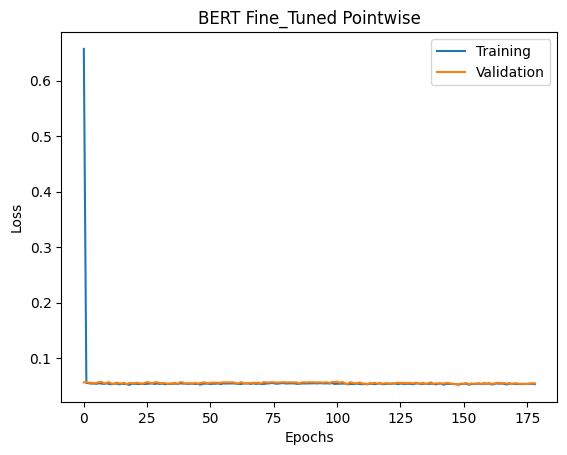

In [ ]:
plt.plot(bert_pt_training_loss, label = 'Training')
plt.plot(bert_pt_val_loss, label = 'Validation')
plt.title("BERT Fine_Tuned Pointwise")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Frozen

In [ ]:
#training
bert_frozen_pointwise = BERT_Pointwise(config, 200, freeze_bert = True, dropout = 0.5).to(device)


num_epochs = 1000
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(bert_frozen_pointwise.parameters(), lr=learning_rate)

bert_pt_training_loss = []
bert_pt_val_loss = []


# Training loop
for epoch in range(num_epochs):
    bert_frozen_pointwise.train()  # Set the model to training mode

    running_loss = 0.0

    # Training the model
    with tqdm(bert_pointwise_train_loader, unit="batch") as tepoch:
          for num_features, input_ids, attention_mask, true_position in tepoch:

              num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

              optimizer.zero_grad()

              pred_position = bert_frozen_pointwise(num_features, input_ids, attention_mask)

              loss = loss_function(pred_position, true_position.unsqueeze(1))

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(bert_pointwise_train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    bert_pt_training_loss.append(average_loss)

    if epoch == 0:
        previous_dev_loss = average_val_loss
        dev_loss_counter = 0
    else:
      if average_val_loss >= previous_dev_loss:
          dev_loss_counter += 1
          previous_dev_loss = average_val_loss
          if dev_loss_counter > 3:
              print("Early Stopping")
              break
      else:
          previous_dev_loss = average_val_loss
          dev_loss_counter = 0

    # Validation loop
    bert_frozen_pointwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(bert_pointwise_valid_loader, unit="batch") as tepoch:

            for num_features, input_ids, attention_mask, true_position in tepoch:

                num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

                pred_position = bert_frozen_pointwise(num_features, input_ids, attention_mask)

                loss = loss_function(pred_position, true_position.unsqueeze(1))

                val_loss += loss.item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(bert_pointwise_valid_loader)
    print(f"Validation Loss: {average_val_loss} \n")
    bert_pt_val_loss.append(average_val_loss)

# Testing loop
bert_frozen_pointwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
  with tqdm(bert_pointwise_test_loader, unit="batch") as tepoch:
        for num_features, input_ids, attention_mask, true_position in tepoch:

                num_features, input_ids, attention_mask, true_position = num_features.to(device), input_ids.to(device), attention_mask.to(device), true_position.to(device)

                pred_position = bert_frozen_pointwise(num_features, input_ids, attention_mask)

                loss = loss_function(pred_position, true_position.unsqueeze(1))

                test_loss += loss.item()

# Print the average test loss
average_test_loss = test_loss / len(bert_pointwise_test_loader)
print(f"Average Test Loss: {average_test_loss}")

In [ ]:
plt.plot(bert_pt_training_loss, label = 'Training')
plt.plot(bert_pt_val_loss, label = 'Validation')
plt.title("BERT Frozen Pointwise")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##Pairwise (Classification)

In [ ]:
df = pd.read_csv("data.csv")
df = df.drop([df.columns[0], df.columns[9]], axis = 1)

# Initialize a defaultdict to store the results
results_dict = defaultdict(list)

# Get unique race IDs
race_ids = df['Race_Id'].unique()

# Iterate over race IDs
for race_id in race_ids:
    # Get the rows for the current race ID
    rows = df[df['Race_Id'] == race_id]

    # Iterate over all combinations of horse IDs in the current race
    for i, j in combinations(rows.index, 2):
        # Store the common information
        results_dict['Race_Id'].append(race_id)
        results_dict['Position_x'].append(rows.loc[i, 'Position'])
        results_dict['Position_y'].append(rows.loc[j, 'Position'])
        results_dict['Prediction_x'].append(rows.loc[i, 'Prediction'])
        results_dict['Prediction_y'].append(rows.loc[j, 'Prediction'])


        # Calculate the differences between the values for each column
        # Calculate the differences between the values for each column
        for col_name in [col for col in rows.columns if col not in ['horse_race_id', 'Position', 'Race_Id', 'Prediction']]:
            col_diff = rows.loc[i, col_name] - rows.loc[j, col_name]
            results_dict[col_name].append(col_diff)

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

def positions(x):
    if x['Position_x'] > x['Position_y']: #if horse 1 finishes later than horse 2
        return 0
    else:
        return 1

results_df['comparison'] = results_df[['Position_x', 'Position_y']].apply(positions, axis = 1)

df = results_df.drop(['Race_Id', 'Position_x', 'Position_y'], axis = 1)

df.head()

In [ ]:
train_and_val_data, test_data = train_test_split( df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_and_val_data, test_size=0.2, random_state=42)

In [ ]:
class BERT_Pairwise_Dataset(Dataset):

    def __init__(self, data, maxlen, tokenizer):
        #Store the contents of the file in a pandas dataframe
        self.df = data.reset_index()
        #Initialize the tokenizer for the desired transformer model
        self.tokenizer = tokenizer
        #Maximum length of the tokens list to keep all the sequences of fixed size
        self.maxlen = maxlen

    def __len__(self):
        return self.df.shape[0]

    def process_text(self, pred_x, pred_y):
        #Preprocess the text to be suitable for the transformer
        tokens_x = self.tokenizer.tokenize(pred_x)
        tokens_y = self.tokenizer.tokenize(pred_y)
        tokens = ['[CLS]'] + tokens_x + ['[SEP]'] + tokens_y + ['[SEP]']
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))]
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]']
        #Obtain the indices of the tokens in the BERT Vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = torch.tensor(input_ids)
        #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attention_mask = (input_ids != 0).long()

        return input_ids, attention_mask


    def __getitem__(self, index):

        # Extract the input features and target
        num_features = torch.tensor(self.df.drop(['index', 'Prediction_x', 'Prediction_y', 'comparison'], axis=1).iloc[index].values, dtype=torch.float32)

        try:
            comparison = self.df.loc[index, 'comparison']
        except:
            comparison = -1.0

        #Select the sentence and label at the specified index in the data frame
        pred_x = self.df.loc[index, 'Prediction_x']

        pred_y = self.df.loc[index, 'Prediction_y']

        inputs_ids, attention_mask = self.process_text(pred_x, pred_y)

        return num_features, inputs_ids, attention_mask, comparison

In [ ]:
BATCH_SIZE = 64
config = AutoConfig.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
## Training Dataset
train_set = BERT_Pairwise_Dataset(data=train_data, maxlen=2*MAX_LEN_TRAIN, tokenizer=tokenizer)    #Note the MAX_LEN_... is exactly the same as in Bert Pointwise as using same predictions
valid_set = BERT_Pairwise_Dataset(data=val_data, maxlen=2*MAX_LEN_VALID, tokenizer=tokenizer)
test_set = BERT_Pairwise_Dataset(data=test_data, maxlen=2*MAX_LEN_TEST, tokenizer=tokenizer)

## Data Loaders
bert_pairwise_train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE)
bert_pairwise_valid_loader = DataLoader(dataset=valid_set, batch_size=BATCH_SIZE)
bert_pairwise_test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE)

In [ ]:

class BERT_Pairwise(BertPreTrainedModel):
    def __init__(self, config, hidden_layer_size, freeze_bert=False, dropout = 0):
        super().__init__(config)
        self.bert = BertModel(config)

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        #The output layer that takes the [CLS] representation and gives an output
        self.cls_linear1 = nn.Linear(config.hidden_size + 7, hidden_layer_size)   #note using BERT embedding then adding the 7 numerical features
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_layer_size,2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)



    def forward(self, num_features, inputs_ids, attention_mask):
        #For first prediction
        #Feed the input to Bert model to obtain contextualized representations
        outputs = self.bert(input_ids= inputs_ids, attention_mask=attention_mask)
        #Obtain the representations of [CLS] heads
        logits = outputs.last_hidden_state[:,0,:]

        X = torch.cat((logits, num_features), -1).to(torch.float32)  #concatenate the numerical and textual data

        output = self.cls_linear1(X)
        output = self.relu1(output)
        output = self.dropout1(output)
        output = self.linear2(output)
        output = self.dropout2(output)
        return F.log_softmax(output, dim=1)



###Fine-Tuned

In [ ]:
#training
bert_pairwise = BERT_Pairwise(config, 200, freeze_bert = False, dropout = 0.5).to(device)

num_epochs = 1000
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(bert_pairwise.parameters(), lr=learning_rate)

bert_pr_training_loss = []
bert_pr_val_loss = []
bert_pr_training_accuracy = []
bert_pr_val_accuracy = []
# Training loop
for epoch in range(num_epochs):
    bert_pairwise.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0
    print("Epoch: ", epoch)
    # Training the model
    with tqdm(bert_pairwise_train_loader, unit="batch") as tepoch:

          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              optimizer.zero_grad()

              pred_comparison = bert_pairwise(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              correct += torch.sum(y_label == y_true).item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(bert_pairwise_train_loader)

    print(f"Loss for Epoch: {epoch + 1}/{num_epochs}, {average_loss}")
    bert_pr_training_loss.append(average_loss)

    print('Training accuracy of epoch: %d %% \n' % (100 * correct / total))
    bert_pr_training_accuracy.append((100 * correct / total))

    # Validation loop
    bert_pointwise.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
       with tqdm(bert_pairwise_valid_loader, unit="batch") as tepoch:
          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              val_loss += loss.item()

              val_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              val_correct += torch.sum(y_label == y_true).item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(bert_pairwise_valid_loader)
    print(f"Validation Loss: {average_val_loss}")
    bert_pr_val_loss.append(average_val_loss)

    print('Validation accuracy of epoch: %d %% \n' % (100 * val_correct / val_total))
    bert_pr_val_accuracy.append((100 * val_correct / val_total))

    if epoch == 0:
        previous_dev_loss = average_val_loss
        dev_loss_counter = 0
    else:
      if average_val_loss >= previous_dev_loss:
          dev_loss_counter += 1
          previous_dev_loss = average_val_loss
          if dev_loss_counter > 3:
              print("Early Stopping")
              break
      else:
          previous_dev_loss = average_val_loss
          dev_loss_counter = 0




# Testing loop
bert_pairwise.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
  with tqdm(bert_pairwise_test_loader, unit="batch") as tepoch:
      for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              test_loss += loss.item()

              test_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              test_correct += torch.sum(y_label == y_true).item()

# Print the average test loss
average_test_loss = test_loss / len(bert_pairwise_test_loader)
print(f"Average Test Loss: {average_test_loss}")
print('Validation accuracy of epoch: %d %% \n' % (100 * test_correct / test_total))


In [ ]:
plt.plot(bert_pr_training_loss, label = 'Training')
plt.plot(bert_pr_val_loss, label = 'Validation')
plt.title("BERT Fine_Tune Pairwise")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(bert_pr_training_accuracy, label = 'Training')
plt.plot(bert_pr_val_accuracy, label = 'Validation')
plt.title("BERT Fine_Tune Pairwise")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

###Frozen

In [ ]:
#training
bert_pairwise_frozen = BERT_Pairwise(config, 200, freeze_bert = True, dropout = 0.5).to(device)

num_epochs = 1000
learning_rate = 0.001

# Define the loss function and optimizer
loss_function = nn.NLLLoss()
optimizer = optim.Adam(bert_pairwise_frozen.parameters(), lr=learning_rate)

bert_fr_pr_training_loss = []
bert_fr_pr_val_loss = []
bert_fr_pr_training_accuracy = []
bert_fr_pr_val_accuracy = []
# Training loop
for epoch in range(num_epochs):
    bert_pairwise_frozen.train()  # Set the model to training mode

    running_loss = 0.0
    correct = 0
    total = 0
    print("Epoch: ", epoch)
    # Training the model
    with tqdm(bert_pairwise_train_loader, unit="batch") as tepoch:

          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              optimizer.zero_grad()

              pred_comparison = bert_pairwise_frozen(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              correct += torch.sum(y_label == y_true).item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(bert_pairwise_train_loader)

    print(f"Loss for Epoch: {epoch + 1}/{num_epochs}, {average_loss}")
    bert_fr_pr_training_loss.append(average_loss)

    print('Training accuracy of epoch: %d %% \n' % (100 * correct / total))
    bert_fr_pr_training_accuracy.append((100 * correct / total))

    # Validation loop
    bert_pairwise_frozen.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    with torch.no_grad():
       with tqdm(bert_pairwise_valid_loader, unit="batch") as tepoch:
          for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise_frozen(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              val_loss += loss.item()

              val_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              val_correct += torch.sum(y_label == y_true).item()

    # Print the validation loss for the epoch.
    average_val_loss = val_loss / len(bert_pairwise_valid_loader)
    print(f"Validation Loss: {average_val_loss}")
    bert_fr_pr_val_loss.append(average_val_loss)

    print('Validation accuracy of epoch: %d %% \n' % (100 * val_correct / val_total))
    bert_fr_pr_val_accuracy.append((100 * val_correct / val_total))


    if epoch == 0:
        previous_dev_loss = average_val_loss
        dev_loss_counter = 0
    else:
      if average_val_loss >= previous_dev_loss:
          dev_loss_counter += 1
          previous_dev_loss = average_val_loss
          if dev_loss_counter > 3:
              print("Early Stopping")
              break
      else:
          previous_dev_loss = average_val_loss
          dev_loss_counter = 0

# Testing loop
bert_pairwise_frozen.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
  with tqdm(bert_pairwise_test_loader, unit="batch") as tepoch:
      for num_features, inputs_ids, attention_mask, true_comparison in tepoch:

              num_features, inputs_ids, attention_mask, true_comparison = num_features.to(device), inputs_ids.to(device), attention_mask.to(device), true_comparison.to(device)

              pred_comparison = bert_pairwise_frozen(num_features, inputs_ids, attention_mask)

              loss = loss_function(pred_comparison, true_comparison)

              test_loss += loss.item()

              test_total += y_true.size(0)
              y_label = torch.argmax(y_pred, axis =1)
              test_correct += torch.sum(y_label == y_true).item()

# Print the average test loss
average_test_loss = test_loss / len(bert_pairwise_test_loader)
print(f"Average Test Loss: {average_test_loss}")
print('Validation accuracy of epoch: %d %% \n' % (100 * test_correct / test_total))


In [ ]:
plt.plot(bert_pr_training_loss, label = 'Training')
plt.plot(bert_pr_val_loss, label = 'Validation')
plt.title("BERT Frozen Pairwise")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(bert_pr_training_accuracy, label = 'Training')
plt.plot(bert_pr_val_accuracy, label = 'Validation')
plt.title("BERT Frozen Pairwise")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Evaluation


##Test Data Processing

In [ ]:
df_pred_test = pd.read_csv("test_preds.csv")

In [ ]:
#for tf_idf: prepare the data

# clean the data

def clean_preds(df_preds):

      df_preds['Race Location'] = df_preds['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

      df_preds = df_preds[df_preds['Date'] != 'Date']  #deleting rows with the column titles
      df_preds = df_preds.reset_index()
      df_preds = df_preds.drop("index", axis = 1)  #dropping index columns
      df_preds = df_preds.replace('[\'NaN\']', np.nan)

      #just want horse-race id and the predictions
      df_preds['race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"] #create race id
      df_preds['horse_race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"]+ "_" + df_preds["Horse Name"] #create horse id
      df_preds = df_preds.drop(["Date", "Time", "Race Location", "Going", "Horse Name"], axis = 1) #drop all data now stored in horse id
      df_preds = df_preds.drop_duplicates()
      df_preds.Prediction = df_preds.Prediction.astype(str)
      df_preds.horse_race_id = df_preds.horse_race_id.astype(str)
      df_preds = df_preds.replace('-', np.nan)

      for i in df_preds.columns[df_preds.isnull().any(axis=0)]:     # replace nan with the mean of a column
          df_preds[i].fillna(pd.to_numeric(df_preds[i]).mean(),inplace=True)


      cols_to_norm = ['Horse Age', 'Horse Top Speed', 'Horse RPRS Ranking', 'Horse ORS Ranking', 'Horse Weight', 'Jockey Last 14', 'Trainer Last 14']

      normalized_df_preds = df_preds[cols_to_norm].astype(float)  #standardize the data
      normalized_df_preds = (normalized_df_preds-normalized_df_preds.mean())/normalized_df_preds.std()


      df_preds[cols_to_norm] = normalized_df_preds
      df_preds['Prediction'] = df_preds['Prediction'].apply(lambda x: x.lower())  #make all lowercase
      df_preds["Prediction"] = df_preds['Prediction'].str.replace('[^\w\s]','')
      df_preds['race_id'] = df_preds['race_id'].apply(lambda x: x.strip())
      return df_preds

df_pred_test = clean_preds(df_pred_test)
df_pred_test.head()

In [ ]:
df_res_test = pd.read_csv("test_results.csv")

In [ ]:

def clean_res(df_res):
    df_res['Race Location'] = df_res['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

    df_res = df_res[df_res['Date'] != 'Date']
    df_res = df_res.drop_duplicates()
    df_res = df_res.reset_index()
    df_res = df_res.drop("index", axis = 1)
    df_res['race_id'] = df_res['Date']+ "_" + df_res['Time'] + "_" + df_res["Race Location"]
    df_res['horse_race_id'] = df_res['Date']+ "_" + df_res['Time'] + "_" + df_res["Race Location"]+ "_" + df_res["Horse Name"]
    df_res = df_res[["race_id", "horse_race_id", "Position"]]

    def get_type(x):  #sometimes position is text ie NR for the horse being a Non_Runne, want to penalise this so give a high score
        try:
            return float(x)
        except:
            return 100


    df_res['Position'] = df_res['Position'].apply(get_type) #apply the above function to Position values
    df_res.reset_index(inplace = True)
    df_res = df_res.drop(["index"], axis = 1)
    df_res.horse_race_id = df_res.horse_race_id.astype(str)
    df_res['race_id'] = df_res['race_id'].apply(lambda x: x.strip())
    return df_res

df_res_test = clean_res(df_res_test)

In [ ]:
grouped = df_res_test.groupby('race_id')

results = pd.DataFrame(columns=['Race_id', 'Predictions'])



for name, group in grouped:
    h_pos = []

    for i, j in enumerate(group['Position'].values):
        h_name = group['horse_race_id'].iloc[i]
        h_pos.append((h_name, j))

    sorted_scores = sorted(h_pos, key = lambda x: x[1])  #although already in order, sort just to make sure

    horse_ranks = [i[0] for i in sorted_scores]

    df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_ranks]})
    results = pd.concat([results, df])

results.head()



##TF_IDF


In [ ]:
def add_tf_idf(df, n):
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the "Prediction" column
    tfidf_separate = tfidf_vectorizer.fit_transform(df["Prediction"])

    # Get the vocabulary and its corresponding indices
    vocab = tfidf_vectorizer.vocabulary_
    vocab_indices = tfidf_vectorizer.get_feature_names_out()

    # Sum the tf-idf values for each word for each document (i.e., summing the columns of the tfidf_separate matrix above)
    combined_tfidf = tfidf_separate.toarray().sum(axis=0)

    # Sort the combined_tfidf values in descending order and take the first n indices
    indices_n_highest = combined_tfidf.argsort()[::-1][:n]

    # Get the words corresponding to the highest tf-idf values
    words_n_highest = [vocab_indices[i] for i in indices_n_highest]

    #perform BOW using the highest tfidf words as our set of words
    bow_counter = CountVectorizer()
    bow_counter.fit(words_n_highest)
    bow_applied = bow_counter.transform(df['Prediction'])

    #add these new values to the dataframe
    df = pd.concat([df.reset_index(drop=True), pd.DataFrame(bow_applied.toarray()).reset_index(drop=True)], axis=1)
    return(df)

#add this new data, can go higher than 100
df_pred_test = add_tf_idf(df_pred_test, 100)

#drop the prediction sentences
df_pred_test = df_pred_test.drop('Prediction', axis = 1)


###Pointwise

In [ ]:
grouped = df_pred_test.groupby('race_id')

pt_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  data = group.drop(['horse_race_id', 'race_id'], axis =1)
  torch_tensor = torch.tensor(data.values)
  pred_scores = pointwise(torch_tensor.to(torch.float32))
  indices = torch.argsort(pred_scores, dim = 0, descending = False)
  horse_names = []
  for i in indices:
    h_name = group['horse_race_id'].iloc[i.item()]
    horse_names.append(h_name)

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_names]})
  pt_preds = pd.concat([pt_preds, df])

pt_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(pt_preds, results, on='Race_id', how = 'inner')
pred_test_df.rename(columns={'Predictions_x': 'Predictions', 'Predictions_y': 'Results'}, inplace=True)

pred_test_df.to_csv("tf_idf_evaluation_pointwise.csv")
pred_test_df.head()

###Pairwise

In [ ]:
#prep data for pairwise

# Initialize a defaultdict to store the results
pr_test = defaultdict(list)

# Get unique race IDs
race_ids = df_pred_test['race_id'].unique()

# Iterate over race IDs
for race_id in race_ids:
    # Get the rows for the current race ID
    rows = df_pred_test[df_pred_test['race_id'] == race_id]

    # Iterate over all combinations of horse IDs in the current race
    for i, j in combinations(rows.index, 2):
        # Store the common information
        pr_test['Race_Id'].append(race_id)
        pr_test['Horse_Id_x'].append(rows.loc[i, 'horse_race_id'])
        pr_test['Horse_Id_y'].append(rows.loc[j, 'horse_race_id'])

        # Calculate the differences between the values for each column
        # Calculate the differences between the values for each column
        for col_name in [col for col in rows.columns if col not in ['horse_race_id', 'race_id']]:
            col_diff = float(rows.loc[i, col_name]) - float(rows.loc[j, col_name])
            pr_test[col_name].append(col_diff)

# Create a DataFrame from the dictionary
pr_test = pd.DataFrame(pr_test)
pr_test.head()

In [ ]:
grouped = pr_test.groupby('Race_Id')

pr_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:
  df_horses = {}

  for i in group['Horse_Id_x'].values:
    if i not in df_horses:
      df_horses[i] = 0

  for i in group['Horse_Id_y'].values:
    if i not in df_horses:
      df_horses[i] = 0

  data = group.drop(['Horse_Id_x', 'Horse_Id_y', 'Race_Id'], axis =1)
  torch_tensor = torch.tensor(data.values)
  pred_scores = pairwise(torch_tensor.to(torch.float32))

  for i, j in enumerate(pred_scores):
    h_1_name = group['Horse_Id_x'].iloc[i]
    h_2_name = group['Horse_Id_y'].iloc[i]

    df_horses[h_1_name] += j[0].item()
    df_horses[h_2_name] += j[1].item()

  horse_scores = []

  for i in df_horses.keys():
    horse_scores.append((i, df_horses[i]))

  sorted_scores = sorted(horse_scores, key = lambda x: x[1], reverse = False)

  horse_ranks = [i[0] for i in sorted_scores]

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_ranks]})
  pr_preds = pd.concat([pr_preds, df])



pr_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(pr_preds, results, on='Race_id', how = 'inner')
pred_test_df.rename(columns={'Predictions_x': 'Predictions', 'Predictions_y': 'Results'}, inplace=True)

pred_test_df.to_csv("tf_idf_evaluation_pairwise.csv")
pred_test_df.head()

##BERT

In [ ]:
df_pred_test = pd.read_csv("preds_test.csv")
#for tf_idf: prepare the data

# clean the data

def clean_preds(df_preds):

      df_preds['Race Location'] = df_preds['Race Location'].str.replace(r'\(.*?\)', '', regex=True)

      df_preds = df_preds[df_preds['Date'] != 'Date']  #deleting rows with the column titles
      df_preds = df_preds.reset_index()
      df_preds = df_preds.drop("index", axis = 1)  #dropping index columns
      df_preds = df_preds.replace('[\'NaN\']', np.nan)

      #just want horse-race id and the predictions
      df_preds['race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"] #create race id
      df_preds['horse_race_id'] = df_preds['Date']+ "_" + df_preds['Time'] + "_" + df_preds["Race Location"]+ "_" + df_preds["Horse Name"] #create horse id
      df_preds = df_preds.drop(["Date", "Time", "Race Location", "Going", "Horse Name"], axis = 1) #drop all data now stored in horse id
      df_preds = df_preds.drop_duplicates()
      df_preds.Prediction = df_preds.Prediction.astype(str)
      df_preds.horse_race_id = df_preds.horse_race_id.astype(str)
      df_preds = df_preds.replace('-', np.nan)

      for i in df_preds.columns[df_preds.isnull().any(axis=0)]:     # replace nan with the mean of a column
          df_preds[i].fillna(pd.to_numeric(df_preds[i]).mean(),inplace=True)


      cols_to_norm = ['Horse Age', 'Horse Top Speed', 'Horse RPRS Ranking', 'Horse ORS Ranking', 'Horse Weight', 'Jockey Last 14', 'Trainer Last 14']

      normalized_df_preds = df_preds[cols_to_norm].astype(float)  #standardize the data
      normalized_df_preds = (normalized_df_preds-normalized_df_preds.mean())/normalized_df_preds.std()


      df_preds[cols_to_norm] = normalized_df_preds
      df_preds['Prediction'] = df_preds['Prediction'].apply(lambda x: x.lower())  #make all lowercase
      df_preds["Prediction"] = df_preds['Prediction'].str.replace('[^\w\s]','')
      df_preds['race_id'] = df_preds['race_id'].apply(lambda x: x.strip())
      return df_preds

df_pred_test = clean_preds(df_pred_test)
df_pred_test.head()

###Pointwise

####Fine Tuned

In [ ]:
grouped = df_pred_test.groupby('race_id')

bert_pt_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  num_features = torch.tensor(group.drop(['Prediction', 'race_id', 'horse_race_id'], axis=1).values, dtype=torch.float32).to(device)

  word_count = group['Prediction'].apply(lambda x: len(x.split()))
  max_word_count = word_count.max()

  ids_per_horse = []
  att_per_horse = []

  for j in group['Prediction']:
    pred = j
    tokens = tokenizer.tokenize(pred)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    if len(tokens) < max_word_count:
        tokens = tokens + ['[PAD]' for _ in range(max_word_count - len(tokens))]
    else:
        tokens = tokens[:max_word_count-1] + ['[SEP]']
    #Obtain the indices of the tokens in the BERT Vocabulary
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor(input_ids)
    #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
    attention_mask = (input_ids != 0).long()

    ids_per_horse.append(input_ids)
    att_per_horse.append(attention_mask)


  tensor_ids = torch.stack(ids_per_horse).to(device)
  tensor_atts = torch.stack(att_per_horse).to(device)

  pred_scores = bert_pointwise(num_features, tensor_ids, tensor_atts)

  indices = torch.argsort(pred_scores, dim = 0, descending = True)
  horse_names = []
  for i in indices:
    h_name = group['horse_race_id'].iloc[i.item()]
    horse_names.append(h_name)

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_names]})
  bert_pt_preds = pd.concat([bert_pt_preds, df])

bert_pt_preds.head()

In [ ]:
#merge
pred_test_df = pd.merge(bert_pt_preds, results, on='Race_id', how = 'inner')
pred_test_df.rename(columns={'Predictions_x': 'Predictions', 'Predictions_y': 'Results'}, inplace=True)

pred_test_df.to_csv("bert_fine_tune_evaluation_pointwise.csv")
pred_test_df.head()

####Frozen

In [ ]:
grouped = df_pred_test.groupby('race_id')

bert_pt_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  num_features = torch.tensor(group.drop(['Prediction', 'race_id', 'horse_race_id'], axis=1).values, dtype=torch.float32).to(device)

  word_count = group['Prediction'].apply(lambda x: len(x.split()))
  max_word_count = word_count.max()

  ids_per_horse = []
  att_per_horse = []

  for j in group['Prediction']:
    pred = j
    tokens = tokenizer.tokenize(pred)
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    if len(tokens) < max_word_count:
        tokens = tokens + ['[PAD]' for _ in range(max_word_count - len(tokens))]
    else:
        tokens = tokens[:max_word_count-1] + ['[SEP]']
    #Obtain the indices of the tokens in the BERT Vocabulary
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor(input_ids)
    #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
    attention_mask = (input_ids != 0).long()

    ids_per_horse.append(input_ids)
    att_per_horse.append(attention_mask)


  tensor_ids = torch.stack(ids_per_horse).to(device)
  tensor_atts = torch.stack(att_per_horse).to(device)

  pred_scores = bert_frozen_pointwise(num_features, tensor_ids, tensor_atts)

  indices = torch.argsort(pred_scores, dim = 0, descending = True)
  horse_names = []
  for i in indices:
    h_name = group['horse_race_id'].iloc[i.item()]
    horse_names.append(h_name)

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_names]})
  bert_pt_preds = pd.concat([bert_pt_preds, df])

bert_pt_preds.head()

In [ ]:
pred_test_df = pd.merge(bert_pt_preds, results, on='Race_id', how = 'inner')
pred_test_df.rename(columns={'Predictions_x': 'Predictions', 'Predictions_y': 'Results'}, inplace=True)

pred_test_df.to_csv("bert_frozen_evaluation_pointwise.csv")
pred_test_df.head()

###Pairwise

In [ ]:
df = df_pred_test

# Initialize a defaultdict to store the results
results_dict = defaultdict(list)

# Get unique race IDs
race_ids = df['race_id'].unique()

# Iterate over race IDs
for race_id in race_ids:
    # Get the rows for the current race ID
    rows = df[df['race_id'] == race_id]

    # Iterate over all combinations of horse IDs in the current race
    for i, j in combinations(rows.index, 2):
        # Store the common information
        results_dict['Race_Id'].append(race_id)
        results_dict['Prediction_x'].append(rows.loc[i, 'Prediction'])
        results_dict['Prediction_y'].append(rows.loc[j, 'Prediction'])
        results_dict['Horse_race_id_x'].append(rows.loc[i, 'horse_race_id'])
        results_dict['Horse_race_id_y'].append(rows.loc[j, 'horse_race_id'])

        # Calculate the differences between the values for each column
        # Calculate the differences between the values for each column
        for col_name in [col for col in rows.columns if col not in ['horse_race_id', 'race_id', 'Prediction']]:
            col_diff = rows.loc[i, col_name] - rows.loc[j, col_name]
            results_dict[col_name].append(col_diff)

# Create a DataFrame from the dictionary
preds_df = pd.DataFrame(results_dict)

preds_df.head()

####Fine-Tuned

In [ ]:
grouped = preds_df.groupby('Race_Id')

bert_pr_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  df_horses = {}

  for i in group['Horse_race_id_x'].values:
    if i not in df_horses:
      df_horses[i] = 0

  for i in group['Horse_race_id_y'].values:
    if i not in df_horses:
      df_horses[i] = 0

  num_features = torch.tensor(group.drop(['Prediction_x', 'Prediction_y', 'Race_Id', 'Horse_race_id_x', 'Horse_race_id_y'], axis=1).values, dtype=torch.float32).to(device)

  word_count_x = group['Prediction_x'].apply(lambda x: len(x.split()))
  word_count_y = group['Prediction_y'].apply(lambda x: len(x.split()))

  max_word_count = max(word_count_x.max(), word_count_y.max())

  ids_per_pair = []
  att_per_pair = []

  for index, row in group.iterrows():
    pred_x = row['Prediction_x']
    tokens_x = tokenizer.tokenize(pred_x)

    pred_y = row['Prediction_y']
    tokens_y = tokenizer.tokenize(pred_y)

    tokens = ['[CLS]'] + tokens_x + ['[SEP]'] + tokens_y + ['[SEP]']

    if len(tokens) < max_word_count:
        tokens = tokens + ['[PAD]' for _ in range(max_word_count - len(tokens))]
    else:
        tokens = tokens[:max_word_count-1] + ['[SEP]']
    #Obtain the indices of the tokens in the BERT Vocabulary
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor(input_ids)
    #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
    attention_mask = (input_ids != 0).long()

    ids_per_pair.append(input_ids)
    att_per_pair.append(attention_mask)


  tensor_ids = torch.stack(ids_per_pair).to(device)
  tensor_atts = torch.stack(att_per_pair).to(device)

  pred_scores = bert_pairwise(num_features, tensor_ids, tensor_atts)

  for i, j in enumerate(pred_scores):
      h_1_name = group['Horse_race_id_x'].iloc[i]
      h_2_name = group['Horse_race_id_y'].iloc[i]

      df_horses[h_1_name] += j[0].item()
      df_horses[h_2_name] += j[1].item()

  horse_scores = []

  for i in df_horses.keys():
      horse_scores.append((i, df_horses[i]))

  sorted_scores = sorted(horse_scores, key = lambda x: x[1], reverse = False)

  horse_ranks = [i[0] for i in sorted_scores]

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_ranks]})
  bert_pr_preds = pd.concat([bert_pr_preds, df])


bert_pr_preds.head()

In [ ]:
#merge

pred_test_df = pd.merge(bert_pr_preds, results, on='Race_id', how = 'inner')
pred_test_df.rename(columns={'Predictions_x': 'Predictions', 'Predictions_y': 'Results'}, inplace=True)

pred_test_df.to_csv("bert_fine_tuned_evaluation_pairwise.csv")
pred_test_df.head()

####Frozen

In [ ]:
grouped = preds_df.groupby('Race_Id')

bert_fr_pr_preds = pd.DataFrame(columns=['Race_id', 'Predictions'])

for name, group in grouped:

  df_horses = {}

  for i in group['Horse_race_id_x'].values:
    if i not in df_horses:
      df_horses[i] = 0

  for i in group['Horse_race_id_y'].values:
    if i not in df_horses:
      df_horses[i] = 0

  num_features = torch.tensor(group.drop(['Prediction_x', 'Prediction_y', 'Race_Id', 'Horse_race_id_x', 'Horse_race_id_y'], axis=1).values, dtype=torch.float32).to(device)

  word_count_x = group['Prediction_x'].apply(lambda x: len(x.split()))
  word_count_y = group['Prediction_y'].apply(lambda x: len(x.split()))

  max_word_count = max(word_count_x.max(), word_count_y.max())

  ids_per_pair = []
  att_per_pair = []

  for index, row in group.iterrows():
    pred_x = row['Prediction_x']
    tokens_x = tokenizer.tokenize(pred_x)

    pred_y = row['Prediction_y']
    tokens_y = tokenizer.tokenize(pred_y)

    tokens = ['[CLS]'] + tokens_x + ['[SEP]'] + tokens_y + ['[SEP]']

    if len(tokens) < max_word_count:
        tokens = tokens + ['[PAD]' for _ in range(max_word_count - len(tokens))]
    else:
        tokens = tokens[:max_word_count-1] + ['[SEP]']
    #Obtain the indices of the tokens in the BERT Vocabulary
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = torch.tensor(input_ids)
    #Obtain the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
    attention_mask = (input_ids != 0).long()

    ids_per_pair.append(input_ids)
    att_per_pair.append(attention_mask)


  tensor_ids = torch.stack(ids_per_pair).to(device)
  tensor_atts = torch.stack(att_per_pair).to(device)

  pred_scores = bert_pairwise_frozen(num_features, tensor_ids, tensor_atts)

  for i, j in enumerate(pred_scores):
      h_1_name = group['Horse_race_id_x'].iloc[i]
      h_2_name = group['Horse_race_id_y'].iloc[i]

      df_horses[h_1_name] += j[0].item()
      df_horses[h_2_name] += j[1].item()

  horse_scores = []

  for i in df_horses.keys():
      horse_scores.append((i, df_horses[i]))

  sorted_scores = sorted(horse_scores, key = lambda x: x[1], reverse = False)

  horse_ranks = [i[0] for i in sorted_scores]

  df = pd.DataFrame({'Race_id': name, 'Predictions': [horse_ranks]})
  bert_fr_pr_preds = pd.concat([bert_fr_pr_preds, df])


bert_fr_pr_preds.head()

In [ ]:
#merge

pred_test_df = pd.merge(bert_fr_pr_preds, results, on='Race_id', how = 'inner')
pred_test_df.rename(columns={'Predictions_x': 'Predictions', 'Predictions_y': 'Results'}, inplace=True)

pred_test_df.to_csv("bert_frozen_evaluation_pairwise.csv")
pred_test_df.head()